#Importing the Necessary Libraries

In [ ]:
!pip install Keras-Preprocessing
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import joblib
import nltk
from nltk.corpus import stopwords, reuters, brown, gutenberg
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from collections import Counter
from textblob import Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
import re
!pip install ktrain
import ktrain
from ktrain import text
sns.set()
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('gutenberg')
nltk.download('brown')
nltk.download("reuters")
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Loading the Dataset

In [ ]:
df=pd.read_csv("/content/bbc-text.csv", engine='python', encoding='UTF-8')
df.head()

category                                               text
0           Tech  tv future in the hands of viewers with home th...
1       Business  worldcom boss  left books alone  former worldc...
2          Sport  tigers wary of farrell  gamble  leicester say ...
3          Sport  yeading face newcastle in fa cup premiership s...
4  Entertainment  ocean s twelve raids box office ocean s twelve...

#Exploratory Data Analysis(EDA)

In [ ]:
df.shape

(2225, 2)

In [ ]:
df.describe().T

count unique                                                top freq
category  2225      5                                              Sport  511
text      2225   2126  kennedy questions trust of blair lib dem leade...    2

In [ ]:
df['category'].value_counts()

Sport            511
Business         510
Politics         417
Tech             401
Entertainment    386
Name: category, dtype: int64

In [ ]:
df['text']=df['text'].fillna("")
df.isna().sum()

category    0
text        0
dtype: int64

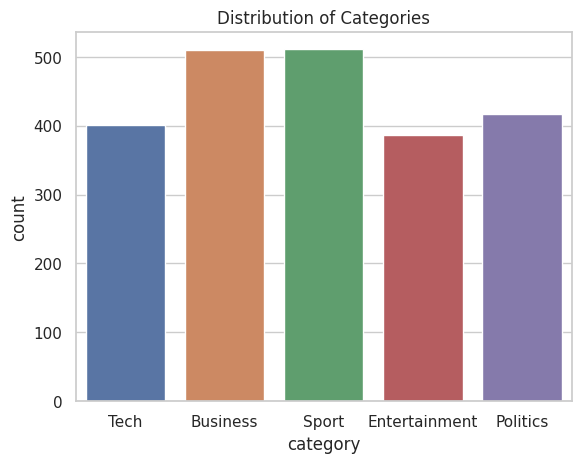

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=df["category"])
plt.title('Distribution of Categories')
plt.show()

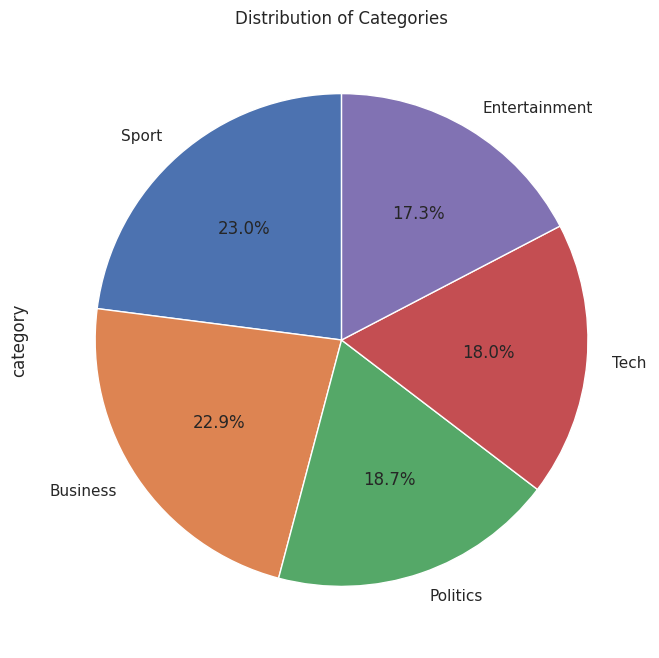

In [ ]:
plt.figure(figsize=(8, 8))
df['category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=[0.0] * len(df['category'].unique()))
plt.title('Distribution of Categories')
plt.show()

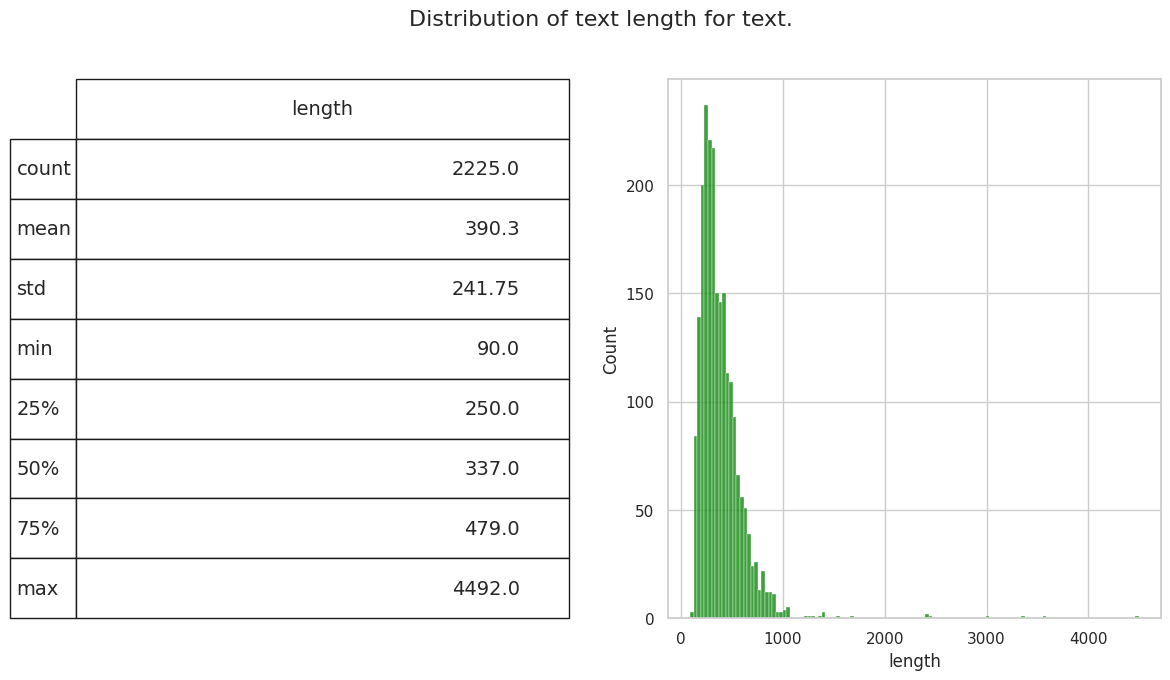

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df['length'], ax=ax1,color='green')
describe = df.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for text.', fontsize=16)

plt.show()

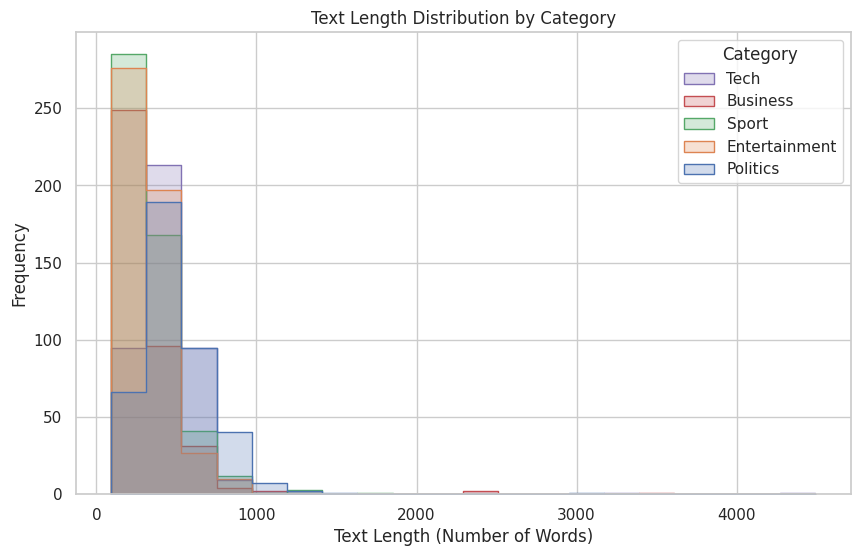

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='category', bins=20, element='step')
plt.title("Text Length Distribution by Category")
plt.xlabel("Text Length (Number of Words)")
plt.ylabel("Frequency")

unique_category = df['category'].unique()
plt.legend(title="Category", labels=unique_category)

plt.show()

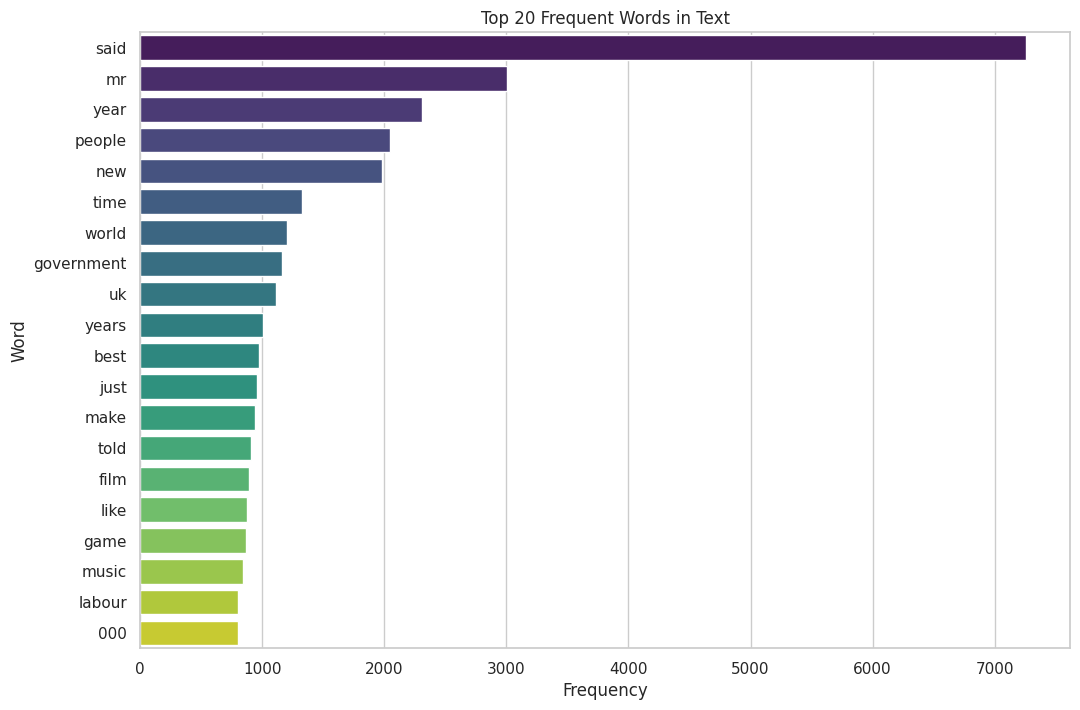

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])

word_freq = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out())
top_words = word_freq.transpose().sort_values(0, ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_words[0], y=top_words.index, palette="viridis")
plt.title('Top 20 Frequent Words in Text')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

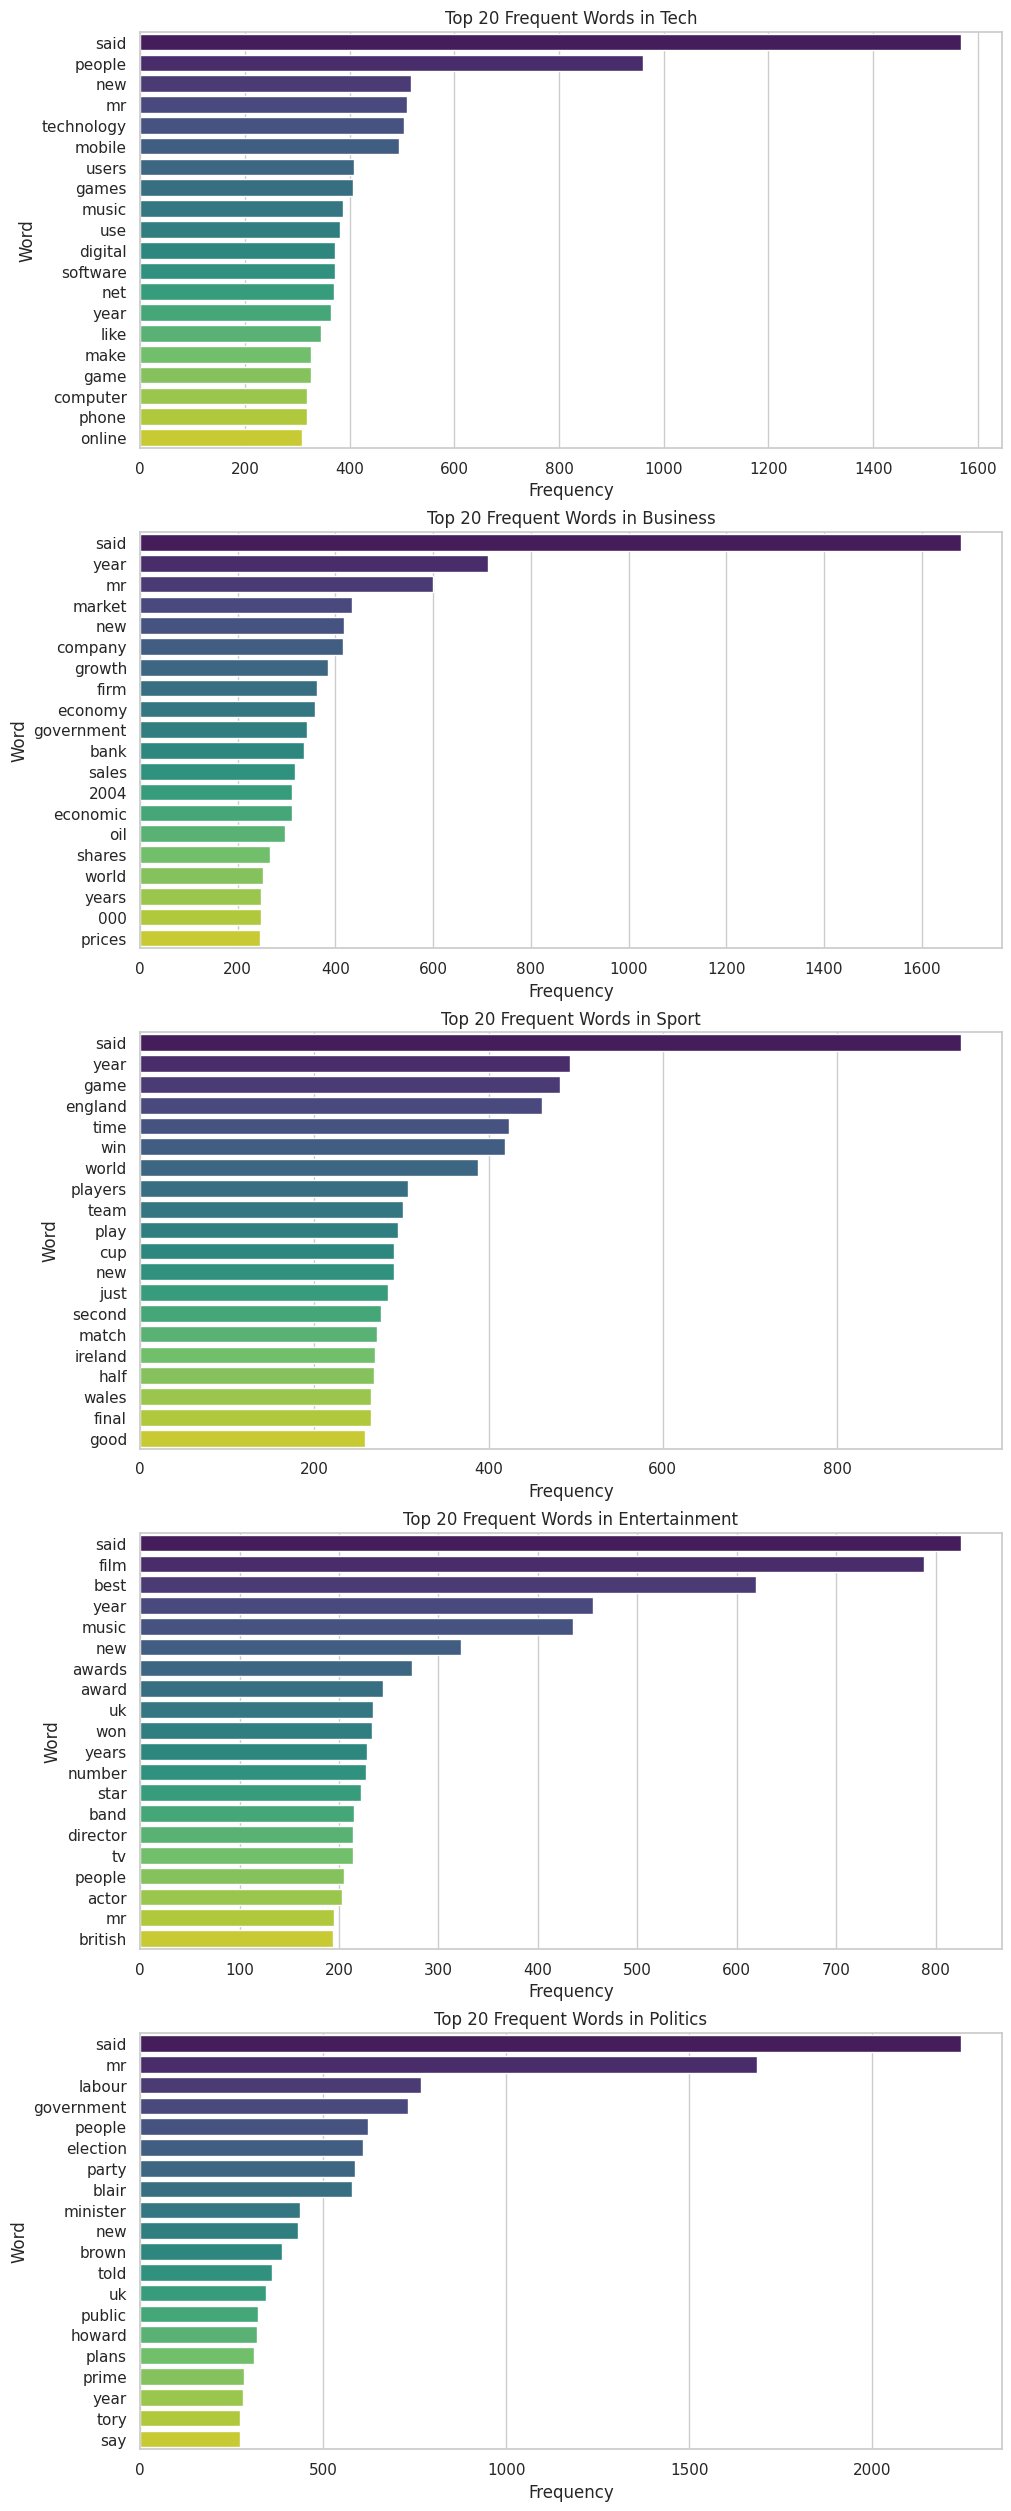

In [ ]:
fig, axes = plt.subplots(nrows=len(df['category'].unique()), ncols=1, figsize=(10, 25), constrained_layout=True)

for ax, category in zip(axes, df['category'].unique()):
    subset_df = df[df['category'] == category]

    X = vectorizer.fit_transform(subset_df['text'])
    word_freq = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out())
    top_words = word_freq.transpose().sort_values(0, ascending=False).head(20)

    sns.barplot(x=top_words[0], y=top_words.index, palette="viridis", ax=ax)
    ax.set_title(f'Top 20 Frequent Words in {category}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Word')

plt.show()

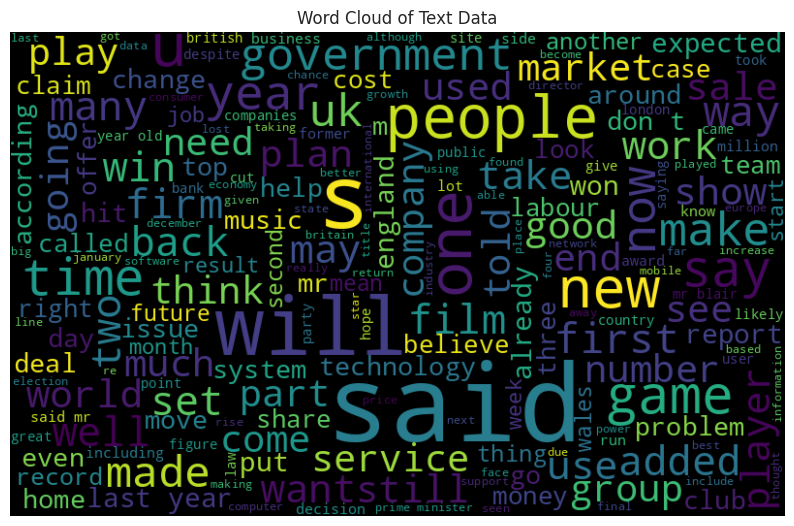

In [ ]:
normal_words =' '.join([text for text in df['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Text Data')
plt.axis('off')
plt.show()

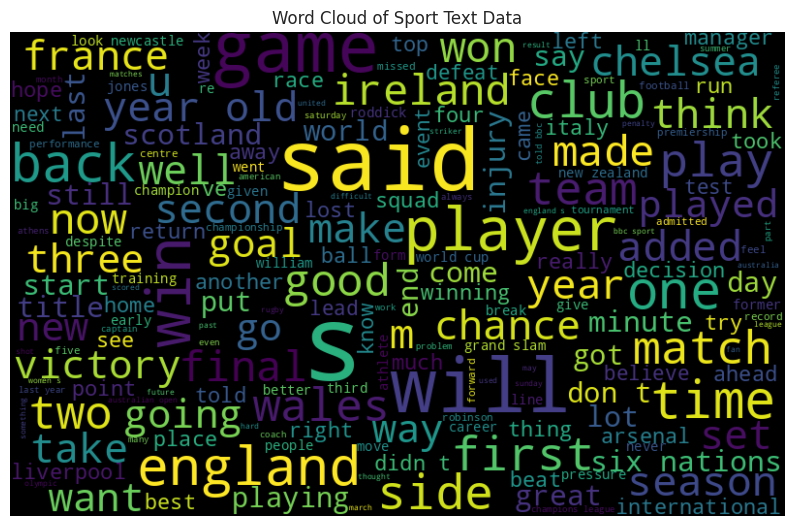

In [ ]:
normal_words =' '.join([text for text in df['text'][df['category'] == 'Sport']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Sport Text Data')
plt.axis('off')
plt.show()

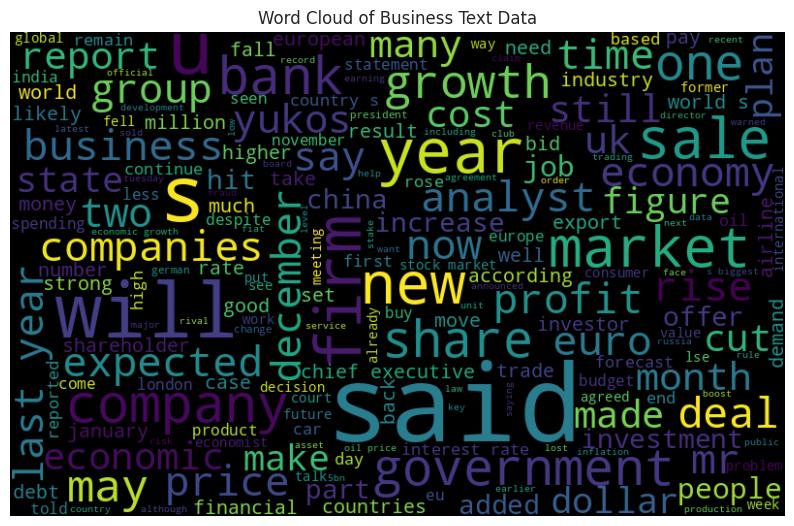

In [ ]:
normal_words =' '.join([text for text in df['text'][df['category'] == 'Business']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Business Text Data')
plt.axis('off')
plt.show()

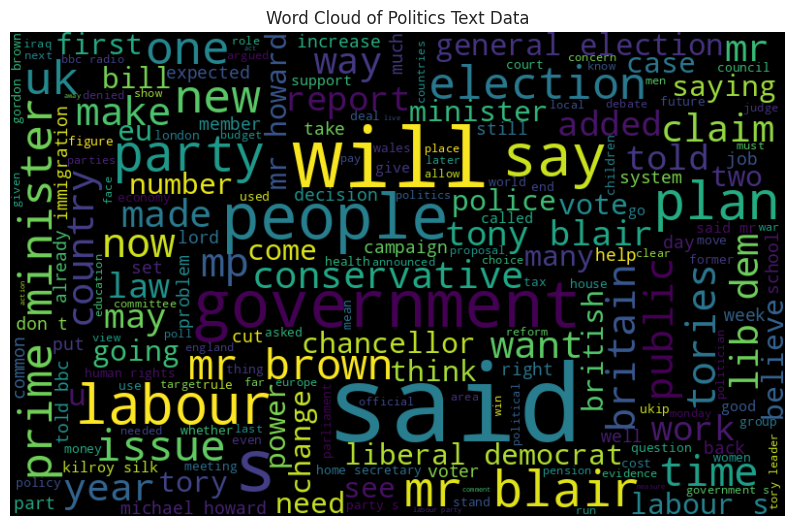

In [ ]:
normal_words =' '.join([text for text in df['text'][df['category'] == 'Politics']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Politics Text Data')
plt.axis('off')
plt.show()

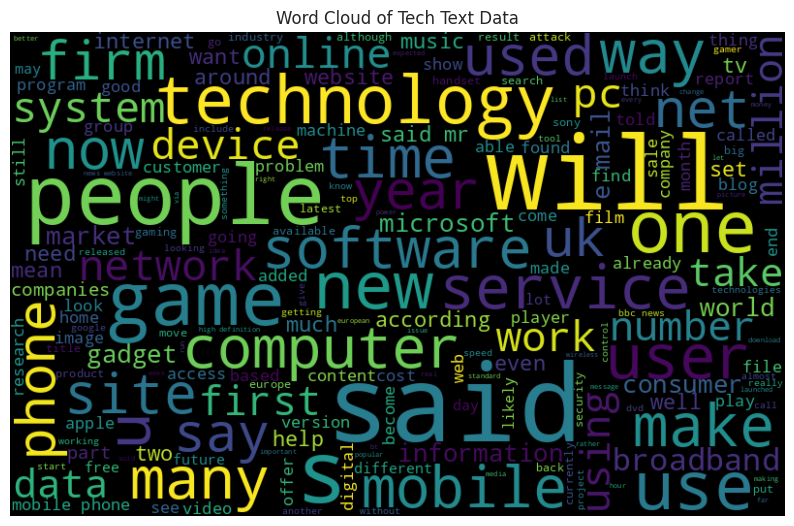

In [ ]:
normal_words =' '.join([text for text in df['text'][df['category'] == 'Tech']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Tech Text Data')
plt.axis('off')
plt.show()

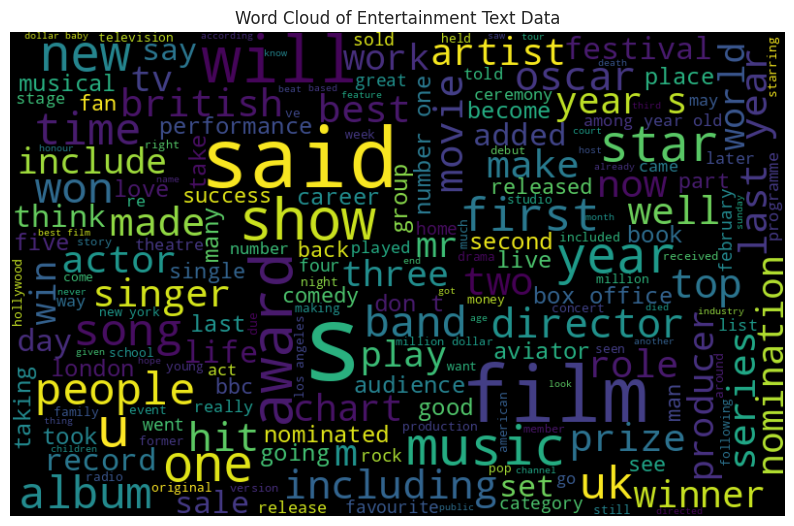

In [ ]:
normal_words =' '.join([text for text in df['text'][df['category'] == 'Entertainment']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Entertainment Text Data')
plt.axis('off')
plt.show()

#Text Cleaning and Preprocessing

In [ ]:
def clean_text(text):
    lower_case = text.lower().strip().replace('\n', ' ').replace('\r', ' ')
    alphabetic = re.sub(r'[^a-zA-Z\']', ' ', lower_case).replace(r'[^\x00-\x7F]+', '')
    without_link = re.sub(r'http\S+', '', alphabetic)
    tokenizer = RegexpTokenizer(r'\w+')
    special_word = tokenizer.tokenize(lower_case)
    stop = [word for word in stopwords.words('english') if word not in ["my", "haven't", "aren't", "can", "no",
                                                                         "why", "through", "herself", "she", "he",
                                                                         "himself", "you", "you're", "myself", "not",
                                                                         "here", "some", "do", "does", "did", "will",
                                                                         "don't", "doesn't", "didn't", "won't", "should",
                                                                         "should've", "couldn't", "mightn't", "mustn't",
                                                                         "shouldn't", "hadn't", "wasn't", "wouldn't"]]

    stop_words = [item for item in special_word if item not in stop]
    stop_words_str = ' '.join(stop_words)
    short_word = re.findall('\w{2,}', stop_words_str)
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = " ".join([lemmatizer.lemmatize(word) for word in short_word])

    return lemmatized_text

df['Text'] = df['text'].apply(clean_text)

In [ ]:
df.head(3)

category                                               text  length  \
0      Tech  tv future in the hands of viewers with home th...     737   
1  Business  worldcom boss  left books alone  former worldc...     300   
2     Sport  tigers wary of farrell  gamble  leicester say ...     246   

                                                Text  
0  tv future hand viewer home theatre system plas...  
1  worldcom bos left book alone former worldcom b...  
2  tiger wary farrell gamble leicester say will n...

#Machine Learning Models

##Text Vectorization and Train-Test Split for BBC Dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df["Text"],df["category"], test_size = 0.20, random_state = 42)
count_vect = CountVectorizer(ngram_range=(1, 2))
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

print (x_train_tfidf.shape,x_test_tfidf.shape, y_train.shape, y_test.shape)

(1780, 299189) (445, 299189) (1780,) (445,)


In [ ]:
joblib.dump(count_vect, 'count_vect.pkl')
#count_vect = joblib.load('count_vect.pkl')

['count_vect.pkl']

##Logistic Regression Model with Hyperparameter Tuning and Evaluation

In [ ]:
lr = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [500, 1000, 1200],
}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(x_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [500, 1000, 1200]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_lr_model = grid_search.best_estimator_
y_pred1 = best_lr_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred1) * 100
classification_rep = classification_report(y_test, y_pred1)

print(f"Accuracy : {accuracy:.2f}%")
print("Classification Report:\n")
print(classification_rep)

Best Hyperparameters: {'C': 10, 'max_iter': 500}
Accuracy : 95.96%
Classification Report:

               precision    recall  f1-score   support

     Business       0.94      0.93      0.94       101
Entertainment       0.99      0.94      0.96        81
     Politics       0.92      0.99      0.95        83
        Sport       0.99      0.99      0.99        98
         Tech       0.96      0.95      0.96        82

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



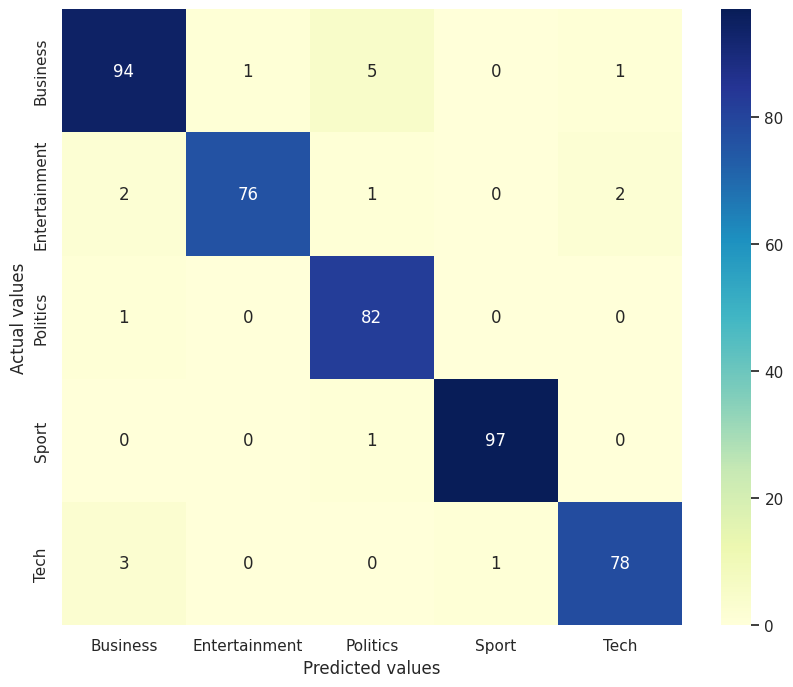

In [ ]:
cm = confusion_matrix(y_test, y_pred1)

plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'], yticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [ ]:
scores = cross_val_score(best_lr_model, x_train_tfidf,y_train, cv=10)

print(f"Accuracy : {accuracy:.2f}%")
print ("Cross-validated scores:", scores)

Accuracy : 95.96%
Cross-validated scores: [0.98876404 0.97191011 0.97191011 0.98314607 0.97191011 0.98314607
 0.99438202 0.97191011 0.98876404 0.98314607]


In [ ]:
mc = count_vect.transform(["howard hits back at mongrel jibe michael howard has said a claim by peter hain that the tory leader is acting like an attack mongrel shows labour is rattled by the opposition. in an upbeat speech to his party s spring conference in brighton he said labour s campaigning tactics proved the tories were hitting home. mr hain made the claim about tory tactics in the anti-terror bill debate. something tells me that someone somewhere out there is just a little bit rattled mr howard said. mr hain leader of the commons told bbc radio four s today programme that mr howard s stance on the government s anti-terrorism legislation was putting the country at risk. he then accused the tory leader of behaving like an attack mongrel and playing opposition for opposition sake . mr howard told his party that labour would do anything say anything claim anything to cling on to office at all costs . so far this year they have compared me to fagin to shylock and to a flying pig. this morning peter hain even called me a mongrel. i don t know about you but something tells me that someone somewhere out there is just a little bit rattled. environment secretary margaret beckett rejected mr howard s comment telling radio 4 s pm programme that labour was not rattled . we have a very real duty to try to get people to focus on michael howard s record what the proposals are that he is trying to put forward to the country and also the many examples we are seeing now of what we believe is really poor judgement on his behalf. mr howard said tory policies on schools taxes immigration and crime were striking a chord with voters. since the beginning of this year - election year - we ve been making the political weather he told the party conference. mr howard denied he had been playing politics by raising the case of margaret dixon whose operation had been cancelled seven times which grabbed headlines for the party two weeks ago. and he hit back at labour claims he had used mrs dixon as a human shield . she s not a human shield mr blair she s a human being. mr howard said his party plans for immigration quotas which have also been the focus of much media coverage were not racist - just common sense . he pledged cleaner hospitals and better school discipline with a promise to get rid of political correctness in the national curriculum and give everyone to the same chance of a decent state education as he had. i come from an ordinary family. if the teenage michael howard were applying to cambridge today gordon brown would love me. and he stressed his party s commitment to cut taxes and red tape and increase the basic state pension in line with earnings. he finished with a personal appeal to party activists to go out and win the next election. one day you will be able to tell your children and grandchildren as i will tell mine i was there. i did my bit. i played my part. i helped to win that famous election - the election that transformed our country for the better . labour election co-ordinator alan milburn said: michael howard s speech today confirms what we have always said - that his only strategy is opportunism but he has no forward vision for the country. in reference to the appearance of mr howard s family on the conference stage with him mr milburn said: michael howard is perfectly entitled to pose with his family today. but it is the hard working families across britain that will be damaged by his plan to cut £35bn from public spending."])
m = transformer.transform(mc)
y_pred = best_lr_model.predict(m)
print(y_pred)

['Politics']


In [ ]:
joblib.dump(lr, 'Text_LR.pkl')
#model = joblib.load('Text_LR.pkl')

['Text_LR.pkl']

##Support Vector Machine Model with Hyperparameter Tuning and Evaluation

In [ ]:
param_grid = {
    'C': [0.1, 0.5, 1, 10],
    'max_iter': [500, 1000, 1500]
}

svc = LinearSVC()

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(x_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 10], 'max_iter': [500, 1000, 1500]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_svc_model = grid_search.best_estimator_

y_pred2 = best_svc_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred2) * 100
classification_rep = classification_report(y_test, y_pred2)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n")
print(classification_rep)

Best Hyperparameters: {'C': 10, 'max_iter': 500}
Accuracy: 96.40%
Classification Report:

               precision    recall  f1-score   support

     Business       0.96      0.93      0.94       101
Entertainment       0.99      0.94      0.96        81
     Politics       0.92      0.99      0.95        83
        Sport       0.99      0.99      0.99        98
         Tech       0.96      0.98      0.97        82

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



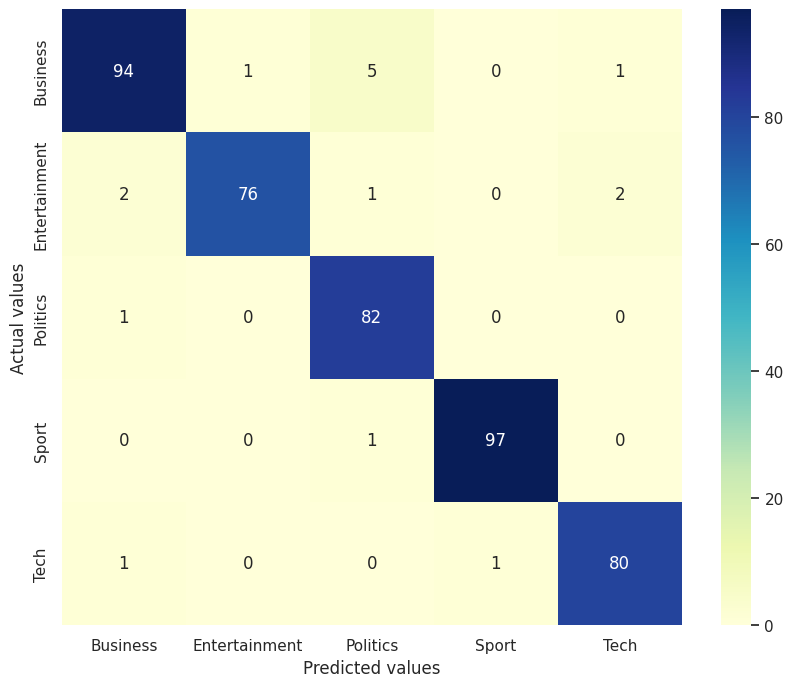

In [ ]:
cm = confusion_matrix(y_test, y_pred2)

plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'], yticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [ ]:
scores = cross_val_score(svc, x_train_tfidf,y_train, cv=10)

print(f"Accuracy: {accuracy:.2f}%")
print ("Cross-validated scores:", scores)

Accuracy: 96.40%
Cross-validated scores: [1.         0.97191011 0.97191011 0.98876404 0.97752809 0.98876404
 1.         0.97752809 0.98876404 0.98314607]


In [ ]:
mc = count_vect.transform(["To combat this trend, we need politicians who are willing to stand up for the interests of the working class. We need leaders who are committed to creating a more just and equitable society, where everyone has a chance to succeed regardless of their background."])
m = transformer.transform(mc)
y_pred = best_svc_model.predict(m)
print(y_pred)

['Politics']


In [ ]:
joblib.dump(svc, 'Text_SVM.pkl')
#model = joblib.load('Text_SVM.pkl')

['Text_SVM.pkl']

##Multinomial Naive Bayes Model with Hyperparameter Tuning and Evaluation

In [ ]:
mnb = MultinomialNB()

param_grid = {
    'alpha': [0.1,0.2, 0.3, 0.8, 1.0, 10.0],
}

grid_search = GridSearchCV(mnb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.8, 1.0, 10.0]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_mnb_model = grid_search.best_estimator_
y_pred3 = best_mnb_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred3) * 100
classification_rep = classification_report(y_test, y_pred3)

print(f"Accuracy: {accuracy:.2f}%")
print("Classification Report:\n")
print(classification_rep)

Best Hyperparameters: {'alpha': 0.1}
Accuracy: 96.18%
Classification Report:

               precision    recall  f1-score   support

     Business       0.97      0.95      0.96       101
Entertainment       1.00      0.89      0.94        81
     Politics       0.90      0.99      0.94        83
        Sport       0.99      1.00      0.99        98
         Tech       0.95      0.98      0.96        82

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



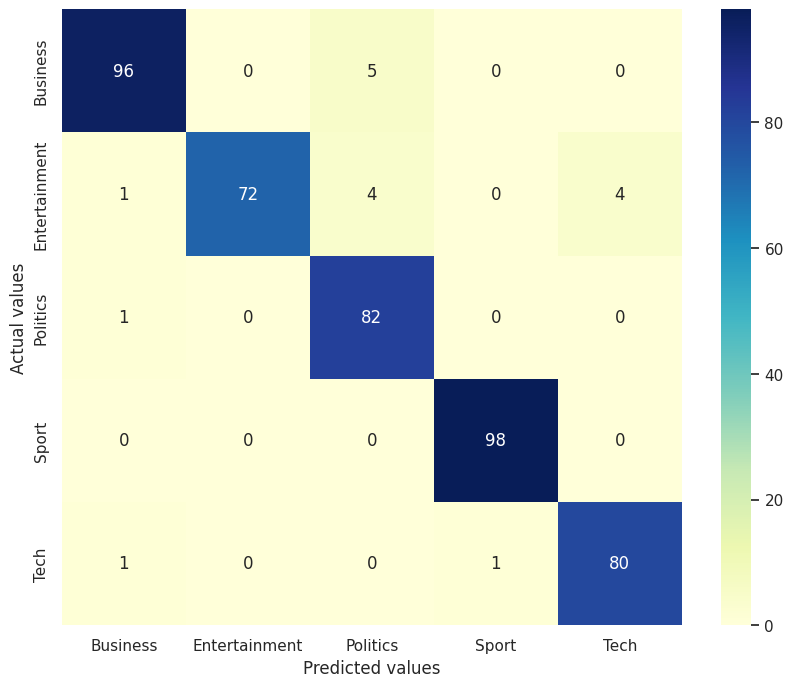

In [ ]:
cm = confusion_matrix(y_test, y_pred3)

plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'], yticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [ ]:
scores = cross_val_score(best_mnb_model, x_train_tfidf,y_train, cv=10)

print(f"Accuracy: {accuracy:.2f}%")
print ("Cross-validated scores:", scores)

Accuracy: 96.18%
Cross-validated scores: [1.         0.97752809 0.97191011 0.97752809 0.96629213 0.97191011
 0.99438202 0.96067416 0.98876404 0.99438202]


In [ ]:
mc = count_vect.transform(["One of the biggest challenges facing politicians today is the growing divide between the rich and poor. The concentration of wealth in the hands of a few individuals is a major threat to our democracy, as it allows a small group of people to exert an outsized influence on our political system."])
m = transformer.transform(mc)
y_pred = best_mnb_model.predict(m)
print(y_pred)

['Politics']


##Randomforest Model with Hyperparameter Tuning and Evaluation


In [ ]:
param_grid = {
    'n_estimators': [300, 500, 1000, 1500],
    'max_depth': [5, 10, 15],
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_tfidf, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [300, 500, 1000, 1500]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_rf_model = grid_search.best_estimator_
y_pred4 = best_rf_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred4) * 100
classification_rep = classification_report(y_test, y_pred4)

print(f"Accuracy : {accuracy:.2f}%")
print("Classification Report:\n")
print(classification_rep)

Best Hyperparameters: {'max_depth': 5, 'n_estimators': 1500}
Accuracy : 94.83%
Classification Report:

               precision    recall  f1-score   support

     Business       0.90      0.93      0.91       101
Entertainment       1.00      0.91      0.95        81
     Politics       0.94      0.95      0.95        83
        Sport       0.95      0.99      0.97        98
         Tech       0.97      0.95      0.96        82

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



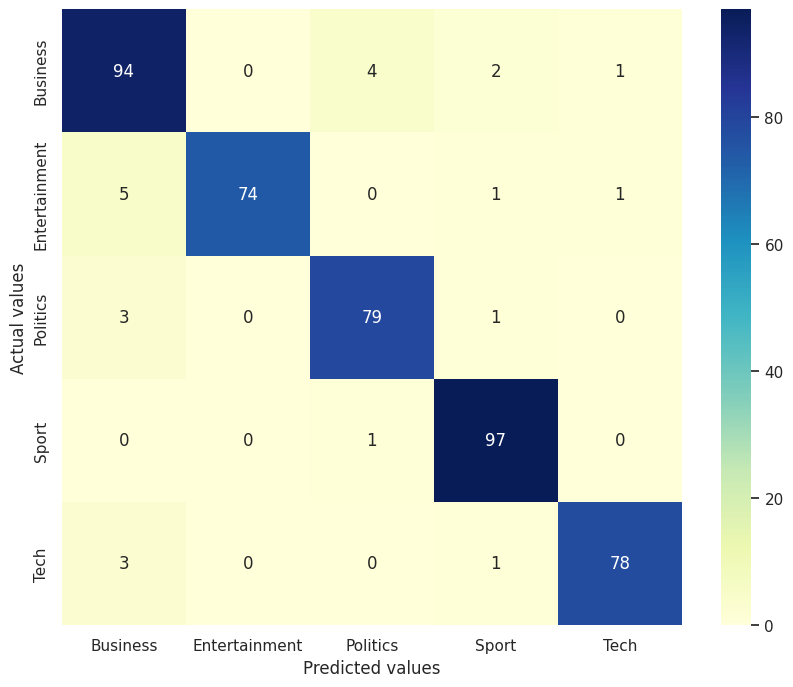

In [ ]:
cm = confusion_matrix(y_test, y_pred4)

plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'], yticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [ ]:
scores = cross_val_score(best_rf_model, x_train_tfidf,y_train, cv=10)

print(f"Accuracy : {accuracy:.2f}%")
print ("Cross-validated scores:", scores)

Accuracy : 94.83%
Cross-validated scores: [0.96067416 0.96629213 0.97191011 0.96067416 0.96067416 0.96067416
 0.96067416 0.94382022 0.97191011 0.97752809]


In [ ]:
mc = count_vect.transform(["But what really set this movie apart for me was the way it integrated Chinese culture and mythology into the story. As a Chinese-American myself, it was incredibly meaningful to see my culture and heritage represented on the big screen in such a beautiful and authentic way. From the stunning visuals to the traditional music and dance, everything felt like it was done with care and respect."])
m = transformer.transform(mc)
y_pred = best_rf_model.predict(m)
print(y_pred)

['Entertainment']


##GradientBoostingClassifier Model Trainning and Evaluation

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, max_features='auto', max_depth=4, random_state=1, verbose=1)
gbc.fit(x_train_tfidf, y_train)
y_pred5 = gbc.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred5) * 100
classification_rep = classification_report(y_test, y_pred5)

print(f"Accuracy : {accuracy:.2f}%")
print("Classification Report:\n")
print(classification_rep)

      Iter       Train Loss   Remaining Time 
         1           1.3234           13.49m
         2           1.1340           12.37m
         3           0.9849           10.77m
         4           0.8681           10.45m
         5           0.7702            9.78m
         6           0.6896            9.27m
         7           0.6214            9.23m
         8           0.5628            8.89m
         9           0.5107            8.70m
        10           0.4637            8.57m
        20           0.2079            7.26m
        30           0.1185            6.26m
        40           0.0770            5.35m
        50           0.0535            4.41m
        60           0.0390            3.54m
        70           0.0288            2.66m
        80           0.0216            1.77m
        90           0.0162           52.68s
       100           0.0123            0.00s
Accuracy : 94.38%
Classification Report:

               precision    recall  f1-score   support

 

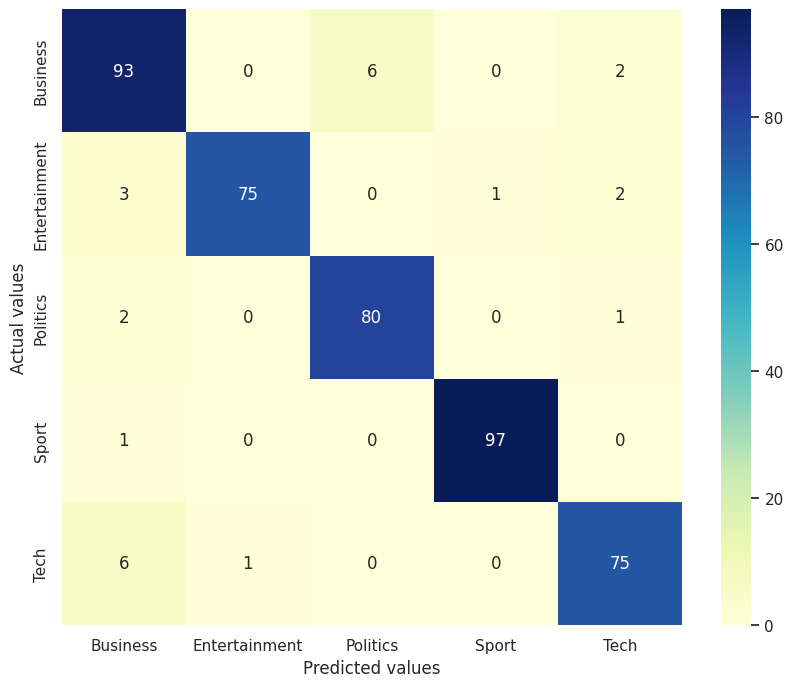

In [ ]:
cm = confusion_matrix(y_test, y_pred5)

plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'], yticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [ ]:
scores = cross_val_score(gbc, x_train_tfidf,y_train, cv=5)

print(f"Accuracy : {accuracy:.2f}%")
print ("Cross-validated scores:", scores)

      Iter       Train Loss   Remaining Time 
         1           1.3187           19.79m
         2           1.1261           16.74m
         3           0.9766           14.58m
         4           0.8600           14.27m
         5           0.7627           13.41m
         6           0.6819           13.29m
         7           0.6154           12.75m
         8           0.5551           12.65m
         9           0.5006           12.19m
        10           0.4538           12.08m
        20           0.2034           10.17m
        30           0.1141            8.71m
        40           0.0719            7.41m
        50           0.0475            6.16m
        60           0.0326            4.93m
        70           0.0230            3.70m
        80           0.0167            2.47m
        90           0.0122            1.23m
       100           0.0088            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3232           11.97m
        

In [ ]:
mc = count_vect.transform(["But what really set this movie apart for me was the way it integrated Chinese culture and mythology into the story. As a Chinese-American myself, it was incredibly meaningful to see my culture and heritage represented on the big screen in such a beautiful and authentic way. From the stunning visuals to the traditional music and dance, everything felt like it was done with care and respect."])
m = transformer.transform(mc)
y_pred = gbc.predict(m)
print(y_pred)

['Entertainment']


##Voting Classifier Model Training and Evaluation

In [ ]:
mnb = MultinomialNB(alpha=0.1)
rfc= RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42)
lr = LogisticRegression(C = 10, max_iter = 1000, n_jobs=-1)
svc = SVC(probability=True)
ec=VotingClassifier(estimators=[('Multinominal NB', mnb), ('Random Forest', rfc),('Logistic Regression',lr),('Support Vector Machine',svc)], voting='soft', weights=[1,2,3,4])
ec.fit(x_train_tfidf,y_train)

y_pred6 = ec.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred6) * 100
classification_rep = classification_report(y_test, y_pred6)

print(f"Accuracy : {accuracy:.2f}%")
print("Classification Report:\n")
print(classification_rep)

Accuracy : 96.40%
Classification Report:

               precision    recall  f1-score   support

     Business       0.97      0.93      0.95       101
Entertainment       0.99      0.94      0.96        81
     Politics       0.92      0.99      0.95        83
        Sport       0.99      0.99      0.99        98
         Tech       0.95      0.98      0.96        82

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



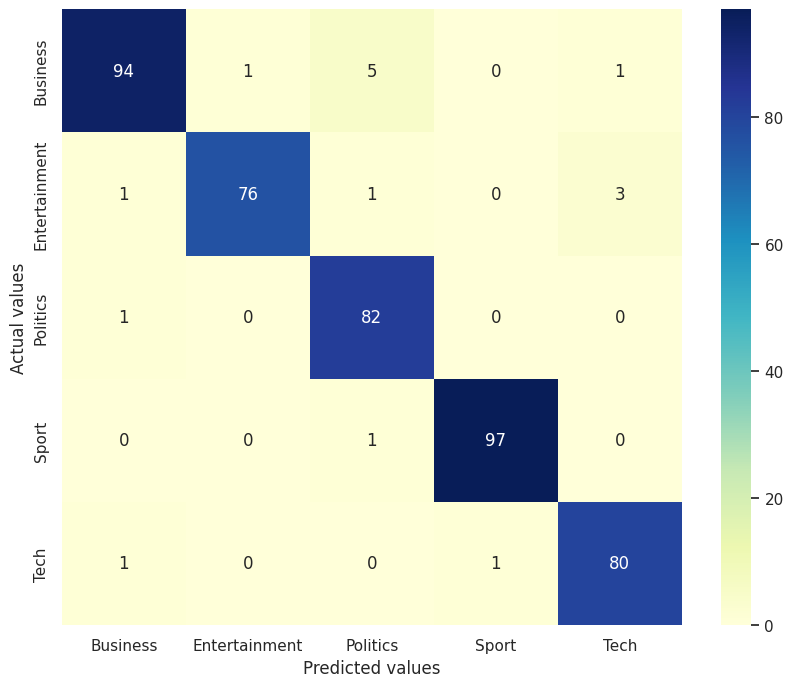

In [ ]:
cm = confusion_matrix(y_test, y_pred6)

plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'], yticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [ ]:
scores = cross_val_score(ec, x_train_tfidf,y_train, cv=10)

print(f"Accuracy : {accuracy:.2f}%")
print ("Cross-validated scores:", scores)

Accuracy : 96.40%
Cross-validated scores: [1.         0.98314607 0.97191011 0.97752809 0.97752809 0.97191011
 0.99438202 0.96629213 0.99438202 0.98314607]


In [ ]:
mc = count_vect.transform(["But what really set this movie apart for me was the way it integrated Chinese culture and mythology into the story. As a Chinese-American myself, it was incredibly meaningful to see my culture and heritage represented on the big screen in such a beautiful and authentic way. From the stunning visuals to the traditional music and dance, everything felt like it was done with care and respect."])
m = transformer.transform(mc)
y_pred = ec.predict(m)
print(y_pred)

['Entertainment']


In [ ]:
joblib.dump(ec, 'Text_Ensemble.pkl')
#model = joblib.load('Text_Ensemble.pkl')

['Text_Ensemble.pkl']

##AdaBoost with Random Forest Classifier Trainning and Evaluation

In [ ]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42)
abc= AdaBoostClassifier(base_estimator=rfc, learning_rate=0.2, n_estimators=100)
abc.fit(x_train_tfidf, y_train)

y_pred7= abc.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred7) * 100
classification_rep = classification_report(y_test, y_pred7)

print(f"Accuracy : {accuracy:.2f}%")
print("Classification Report:\n")
print(classification_rep)

Accuracy : 94.16%
Classification Report:

               precision    recall  f1-score   support

     Business       0.85      0.97      0.91       101
Entertainment       0.99      0.90      0.94        81
     Politics       0.96      0.89      0.92        83
        Sport       0.95      0.99      0.97        98
         Tech       1.00      0.94      0.97        82

     accuracy                           0.94       445
    macro avg       0.95      0.94      0.94       445
 weighted avg       0.95      0.94      0.94       445



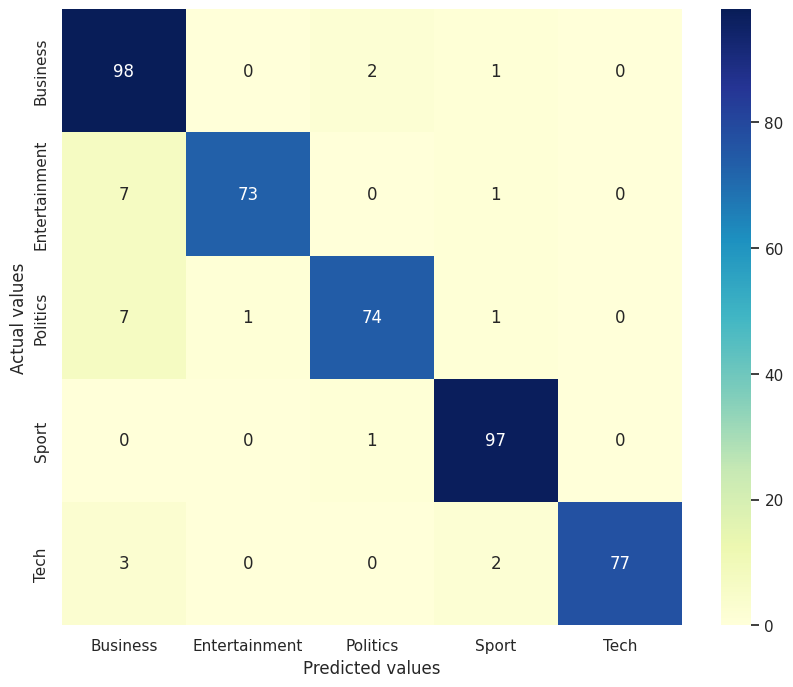

In [ ]:
cm = confusion_matrix(y_test, y_pred7)

plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'], yticklabels=['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [ ]:
scores = cross_val_score(abc, x_train_tfidf,y_train, cv=5)

print(f"Accuracy : {accuracy:.2f}%")
print ("Cross-validated scores:", scores)

Accuracy : 94.16%
Cross-validated scores: [0.94382022 0.9494382  0.93820225 0.95224719 0.9494382 ]


##Comparison Between ML Models

In [ ]:
Comparison_unibi = pd.DataFrame({'Logistic Regression': [accuracy_score(y_test,y_pred1)*100,f1_score(y_test,y_pred1,average='macro')*100,recall_score(y_test, y_pred1,average='micro')*100,precision_score(y_test, y_pred1,average='micro')*100],
                            'SVM':[accuracy_score(y_test,y_pred2)*100,f1_score(y_test,y_pred2,average='macro')*100,recall_score(y_test, y_pred2,average='micro')*100,precision_score(y_test, y_pred2,average='micro')*100],
                           'Naive Bayes':[accuracy_score(y_test,y_pred3)*100,f1_score(y_test,y_pred3,average='macro')*100,recall_score(y_test, y_pred3,average='micro')*100,precision_score(y_test, y_pred3,average='micro')*100],
                           'Random Forest':[accuracy_score(y_test,y_pred4)*100,f1_score(y_test,y_pred4,average='macro')*100,recall_score(y_test, y_pred4,average='micro')*100,precision_score(y_test, y_pred4,average='micro')*100],
                           'GradientBoosting':[accuracy_score(y_test,y_pred5)*100,f1_score(y_test,y_pred5,average='macro')*100,recall_score(y_test, y_pred5,average='micro')*100,precision_score(y_test, y_pred5,average='micro')*100],
                           'Ensembled':[accuracy_score(y_test,y_pred6)*100,f1_score(y_test,y_pred6,average='macro')*100,recall_score(y_test, y_pred6,average='micro')*100,precision_score(y_test, y_pred6,average='micro')*100],
                           'Adaboost':[accuracy_score(y_test,y_pred7)*100,f1_score(y_test,y_pred7,average='macro')*100,recall_score(y_test, y_pred7,average='micro')*100,precision_score(y_test, y_pred7,average='micro')*100],

})

In [ ]:
print ('Comparison using uni-bi-gram(1,2)')
Comparison_unibi.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
Comparison_unibi.head()

Comparison using uni-bi-gram(1,2)


Logistic Regression        SVM  Naive Bayes  Random Forest  \
Accuracy             95.955056  96.404494    96.179775      94.831461   
F1_score             95.953764  96.394604    96.049690      94.930616   
Recall               95.955056  96.404494    96.179775      94.831461   
Precision            95.955056  96.404494    96.179775      94.831461   

           GradientBoosting  Ensembled   Adaboost  
Accuracy          94.382022  96.404494  93.932584  
F1_score          94.415881  96.373200  94.045534  
Recall            94.382022  96.404494  93.932584  
Precision         94.382022  96.404494  93.932584

# **Deep Learning Models**

##Tokenization and Data Preparation for Multi-Class Text Classification using Deep Learning

In [ ]:
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])

In [ ]:
X = df['text']
y = df['category']
XX_train, XX_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(XX_train)
XX_train = tokenizer.texts_to_sequences(XX_train)
XX_test = tokenizer.texts_to_sequences(XX_test)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

26896


In [ ]:
max_length = 768
XX_train = pad_sequences(XX_train, maxlen=max_length)
XX_test = pad_sequences(XX_test, maxlen=max_length)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

##LSTM Model Training and Evaluation

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_lstm.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_lstm.add(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_lstm.add(LSTM(32, return_sequences=True))
model_lstm.add(LSTM(16, return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(Flatten())
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 768, 128)          3442688   
                                                                 
 lstm_8 (LSTM)               (None, 768, 128)          131584    
                                                                 
 lstm_9 (LSTM)               (None, 768, 64)           49408     
                                                                 
 lstm_10 (LSTM)              (None, 768, 32)           12416     
                                                                 
 lstm_11 (LSTM)              (None, 768, 16)           3136      
                                                                 
 dropout_4 (Dropout)         (None, 768, 16)           0         
                                                                 
 flatten_2 (Flatten)         (None, 12288)            

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_lstm = model_lstm.fit(XX_train, y_train, epochs = 5, batch_size = 32, validation_data=(XX_test,y_test), callbacks=callbacks)

Epoch 1/5
56/56 [==============================] - 414s 7s/step - loss: 1.2901 - accuracy: 0.4101 - val_loss: 0.6833 - val_accuracy: 0.7371 - lr: 0.0010
Epoch 2/5
56/56 [==============================] - 403s 7s/step - loss: 0.3006 - accuracy: 0.9051 - val_loss: 0.3337 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 3/5
56/56 [==============================] - 399s 7s/step - loss: 0.0371 - accuracy: 0.9893 - val_loss: 0.2555 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 4/5
56/56 [==============================] - 396s 7s/step - loss: 0.0168 - accuracy: 0.9944 - val_loss: 0.4725 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 5/5
56/56 [==============================] - 395s 7s/step - loss: 0.0111 - accuracy: 0.9972 - val_loss: 0.2637 - val_accuracy: 0.9258 - lr: 0.0010


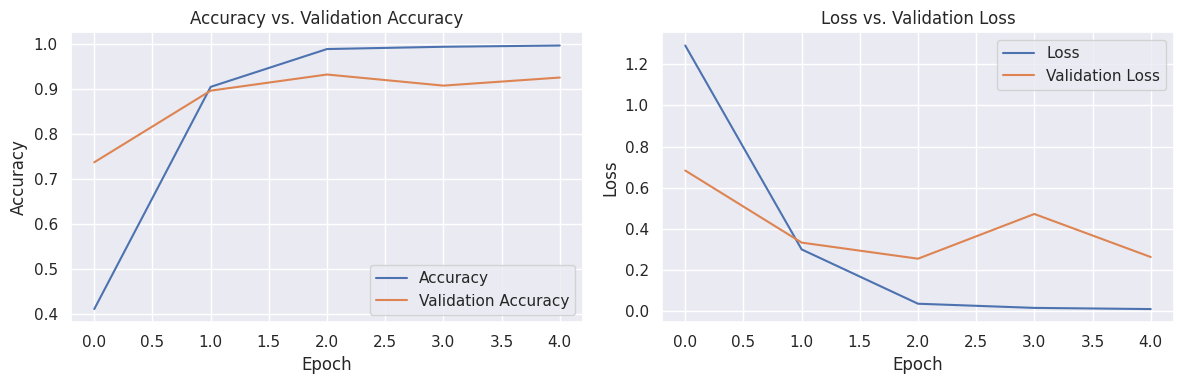

In [ ]:
accuracy = history_lstm.history['accuracy']
val_accuracy = history_lstm.history['val_accuracy']
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
hist_=pd.DataFrame(history_lstm.history)
hist_

loss  accuracy  val_loss  val_accuracy     lr
0  1.290085  0.410112  0.683343      0.737079  0.001
1  0.300609  0.905056  0.333659      0.896629  0.001
2  0.037057  0.989326  0.255547      0.932584  0.001
3  0.016840  0.994382  0.472549      0.907865  0.001
4  0.011115  0.997191  0.263683      0.925843  0.001

In [ ]:
loss, accuracy = model_lstm.evaluate(XX_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

14/14 [==============================] - 5s 378ms/step - loss: 0.2637 - accuracy: 0.9258
Test Loss: 0.2637
Test Accuracy: 92.58%


In [ ]:
class_names = label_encoder.classes_


y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_lstm.predict(XX_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

14/14 [==============================] - 7s 498ms/step
Classification Report:
                precision    recall  f1-score   support

     Business       0.95      0.88      0.91       101
Entertainment       0.94      0.83      0.88        81
     Politics       0.93      0.92      0.92        83
        Sport       0.89      1.00      0.94        98
         Tech       0.93      1.00      0.96        82

     accuracy                           0.93       445
    macro avg       0.93      0.92      0.92       445
 weighted avg       0.93      0.93      0.92       445



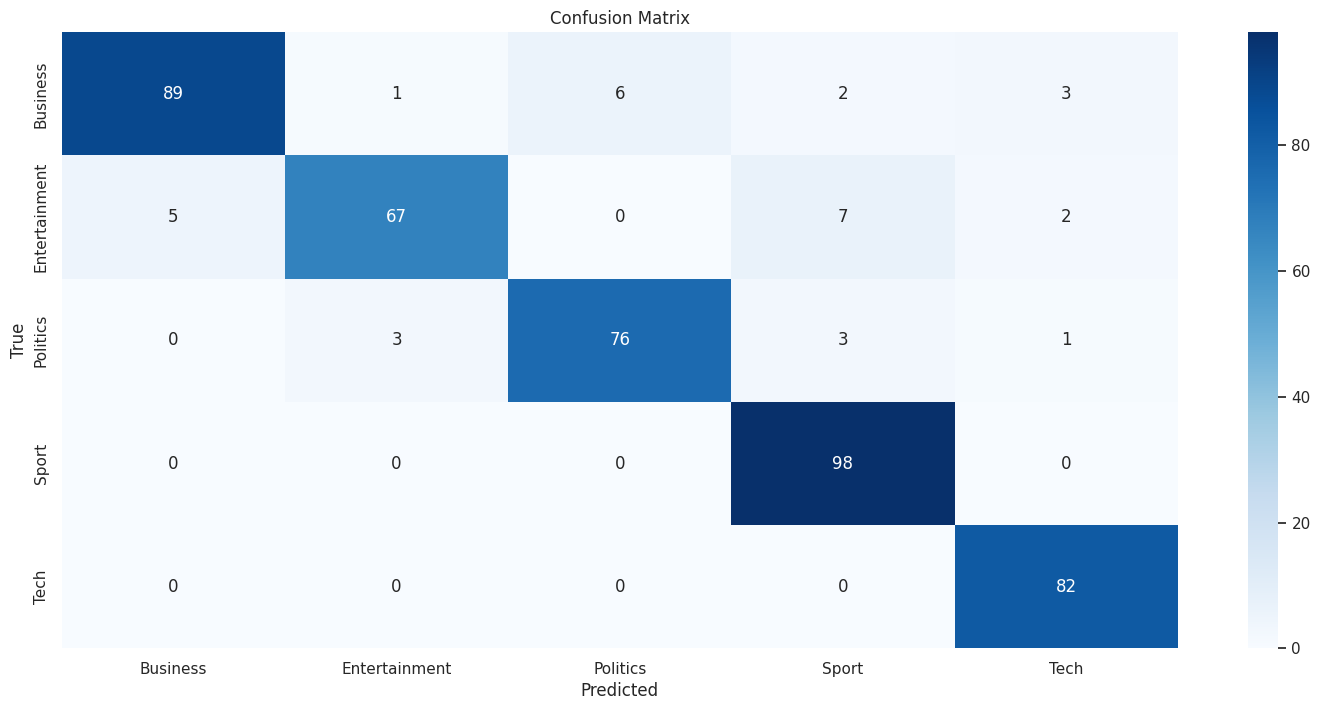

In [ ]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_text(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        sequences = tokenizer.texts_to_sequences([text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_text = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_text, probabilities.max()))

    return predictions

texts = [
    "Berlin, Germany - October 14, 2023 - In a stunning display of athleticism and endurance, John Smith, the 28-year-old long-distance running sensation, left the world in awe as he shattered the men's marathon world record in the 2023 Berlin Marathon.",
    "berlin cheers for anti-nazi film a german movie about an anti-nazi resistance heroine has drawn loud applause at berlin film festival. sophie scholl - the final days portrays the final days of the member of the white rose movement. scholl 21 was arrested and beheaded with her brother hans in 1943 for distributing leaflets condemning the abhorrent tyranny of adolf hitler. director marc rothemund said: i have a feeling of responsibility to keep the legacy of the scholls going. we must somehow keep their ideas alive he added. the film drew on transcripts of gestapo interrogations and scholl s trial preserved in the archive of communist east germany s secret police. their discovery was the inspiration behind the film for rothemund who worked closely with surviving relatives including one of scholl s sisters to ensure historical accuracy on the film. scholl and other members of the white rose resistance group first started distributing anti-nazi leaflets in the summer of 1942. they were arrested as they dropped leaflets at munich university calling for a day of reckoning with adolf hitler s regime. the film focuses on the six days from scholl s arrest to the intense trial which saw scholl initially deny the charges and ended with a defiant appearance. it is one of three german films vying for a top prize at the festival. a south african film version of bizet s tragic opera carmen shot in cape town in the xhosa language has also premiered at the berlin festival. the film is entitled u-carmen ekhayelitsha or carmen in khayelitsha after the township in which the story is set. it is performed by a 40-strong music and theatre troupe in their debut film performance. the film is the first south african feature in 25 years and only the second to be nominated for a golden bear award.",
    "howard backs stem cell research michael howard has backed stem cell research saying it is important people are not frightened of the future. the controversial issue was a feature of the recent us presidential election where george bush opposed extending it. but the tory leader argued there was a moral case for embracing science which could help victims of alzheimer s parkinson s and motor neurone disease. i believe we have a duty to offer hope to the millions of people who suffer devastating illnesses he said. the use of embryonic stem cells in the uk is already allowed. stem cells are master cells that have the ability to develop into any of the body s tissue types. scientists hope that by growing such cells in the laboratory they can programme them to form specific tissue such as kidney heart or even brain tissue. mr howard acknowledged there were genuine concerns about stem cell research. but he argued: we mustn t be frightened of change or nostalgic about the past - we must be optimistic about the future. politicians must create the right framework so that the great potential of science can be harnessed for the benefit of mankind. with the life expectancy of the average briton now around the mid-70s society has a responsibility to enhance the quality of people s lives as they grow older. i know many people are concerned about stem-cell research. they are fearful of meddling with what they see as the stuff of souls. i respect those concerns. but i also believe we have a duty to offer hope to the millions of people who suffer devastating illnesses like parkinson s multiple sclerosis motor neurone disease alzheimer s and - as we saw in the papers today - now possibly heart problems. mr howard acknowledged there were no easy answers over such an issue but it was necessary to have the courage to do what we know to be morally right . he added: of course stem cells are still a recent discovery. more research needs to be done. but we must look at their potential in a responsible and grown-up way. the hopes of millions of people rest on what could be achieved. former superman actor the late christopher reeve was an advocate for the research after he was paralysed in a horse riding accident. mr howard made his remarks during a speech in westminster to the conservative national women s committee on ambitions and values.",
    "security warning over fbi virus the us federal bureau of investigation is warning that a computer virus is being spread via e-mails that purport to be from the fbi. the e-mails show that they have come from an fbi.gov address and tell recipients that they have accessed illegal websites. the messages warn that their internet use has been monitored by the fbi s internet fraud complaint center. an attachment in the e-mail contains the virus the fbi said. the message asks recipients to click on the attachment and answer some questions about their internet use. but rather than being a questionnaire the attachment contains a virus that infects the recipient s computer according to the agency. it is not clear what the virus does once it has infected a computer. users are warned never to open attachment from unsolicited e-mails or from people they do not know. recipients of this or similar solicitations should know that the fbi does not engage in the practice of sending unsolicited e-mails to the public in this manner the fbi said in a statement. the bureau is investigating the phoney e-mails. the agency earlier this month shut down fbi.gov accounts used to communicate with the public because of a security breach. a spokeswoman said the two incidents appear to be unrelated."
]

predicted_texts = predict_text( texts, model_lstm, tokenizer, max_length, label_encoder)

for text, (predicted_text, probability) in zip(texts, predicted_texts):
    print(f"Text: '{text}'")
    print(f"Predicted Category: {predicted_text}")
    print(f"Probability of {predicted_text}: {probability:.4f}\n")


1/1 [==============================] - 0s 382ms/step
Text: 'Berlin, Germany - October 14, 2023 - In a stunning display of athleticism and endurance, John Smith, the 28-year-old long-distance running sensation, left the world in awe as he shattered the men's marathon world record in the 2023 Berlin Marathon.'
Predicted Language: Sport
Probability of Sport: 0.9302

Text: 'berlin cheers for anti-nazi film a german movie about an anti-nazi resistance heroine has drawn loud applause at berlin film festival. sophie scholl - the final days portrays the final days of the member of the white rose movement. scholl 21 was arrested and beheaded with her brother hans in 1943 for distributing leaflets condemning the abhorrent tyranny of adolf hitler. director marc rothemund said: i have a feeling of responsibility to keep the legacy of the scholls going. we must somehow keep their ideas alive he added. the film drew on transcripts of gestapo interrogations and scholl s trial preserved in the archive

##GRU Model Training and Evaluation

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_gru.add(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_gru.add(GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_gru.add(GRU(32, return_sequences=True))
model_gru.add(GRU(16, return_sequences=True))
model_gru.add(Dropout(0.3))
model_gru.add(Flatten())
model_gru.add(Dense(128, activation='relu'))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 768, 128)          3442688   
                                                                 
 gru_11 (GRU)                (None, 768, 128)          99072     
                                                                 
 gru_12 (GRU)                (None, 768, 64)           37248     
                                                                 
 gru_13 (GRU)                (None, 768, 32)           9408      
                                                                 
 gru_14 (GRU)                (None, 768, 16)           2400      
                                                                 
 dropout_10 (Dropout)        (None, 768, 16)           0         
                                                                 
 flatten_2 (Flatten)         (None, 12288)            

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="gru-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks2=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_gru = model_gru.fit(XX_train, y_train, epochs=5, batch_size=64,validation_data=(XX_test,y_test), callbacks=callbacks2)

Epoch 1/5
28/28 [==============================] - 205s 7s/step - loss: 1.5047 - accuracy: 0.3337 - val_loss: 1.0839 - val_accuracy: 0.6022 - lr: 0.0010
Epoch 2/5
28/28 [==============================] - 185s 7s/step - loss: 0.5461 - accuracy: 0.8039 - val_loss: 0.4366 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 3/5
28/28 [==============================] - 186s 7s/step - loss: 0.0899 - accuracy: 0.9657 - val_loss: 0.3341 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 4/5
28/28 [==============================] - 190s 7s/step - loss: 0.0234 - accuracy: 0.9944 - val_loss: 0.3002 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 5/5
28/28 [==============================] - 187s 7s/step - loss: 0.0126 - accuracy: 0.9972 - val_loss: 0.4296 - val_accuracy: 0.9124 - lr: 0.0010


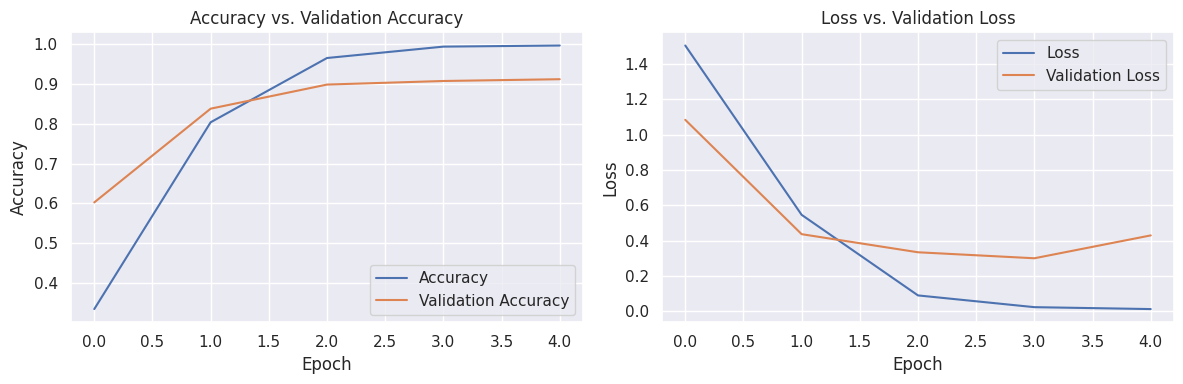

In [ ]:
accuracy = history_gru.history['accuracy']
val_accuracy = history_gru.history['val_accuracy']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
hist_=pd.DataFrame(history_gru.history)
hist_

loss  accuracy  val_loss  val_accuracy     lr
0  1.504650  0.333708  1.083858      0.602247  0.001
1  0.546063  0.803933  0.436612      0.838202  0.001
2  0.089887  0.965730  0.334129      0.898876  0.001
3  0.023385  0.994382  0.300191      0.907865  0.001
4  0.012582  0.997191  0.429624      0.912360  0.001

In [ ]:
loss, accuracy = model_gru.evaluate(XX_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

14/14 [==============================] - 12s 840ms/step - loss: 0.4296 - accuracy: 0.9124
Test Loss: 0.4296
Test Accuracy: 91.24%


In [ ]:
class_names = label_encoder.classes_

y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_gru.predict(XX_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

14/14 [==============================] - 7s 493ms/step
Classification Report:
                precision    recall  f1-score   support

     Business       0.99      0.84      0.91       101
Entertainment       0.85      0.89      0.87        81
     Politics       0.79      0.93      0.86        83
        Sport       0.99      0.94      0.96        98
         Tech       0.95      0.98      0.96        82

     accuracy                           0.91       445
    macro avg       0.91      0.91      0.91       445
 weighted avg       0.92      0.91      0.91       445



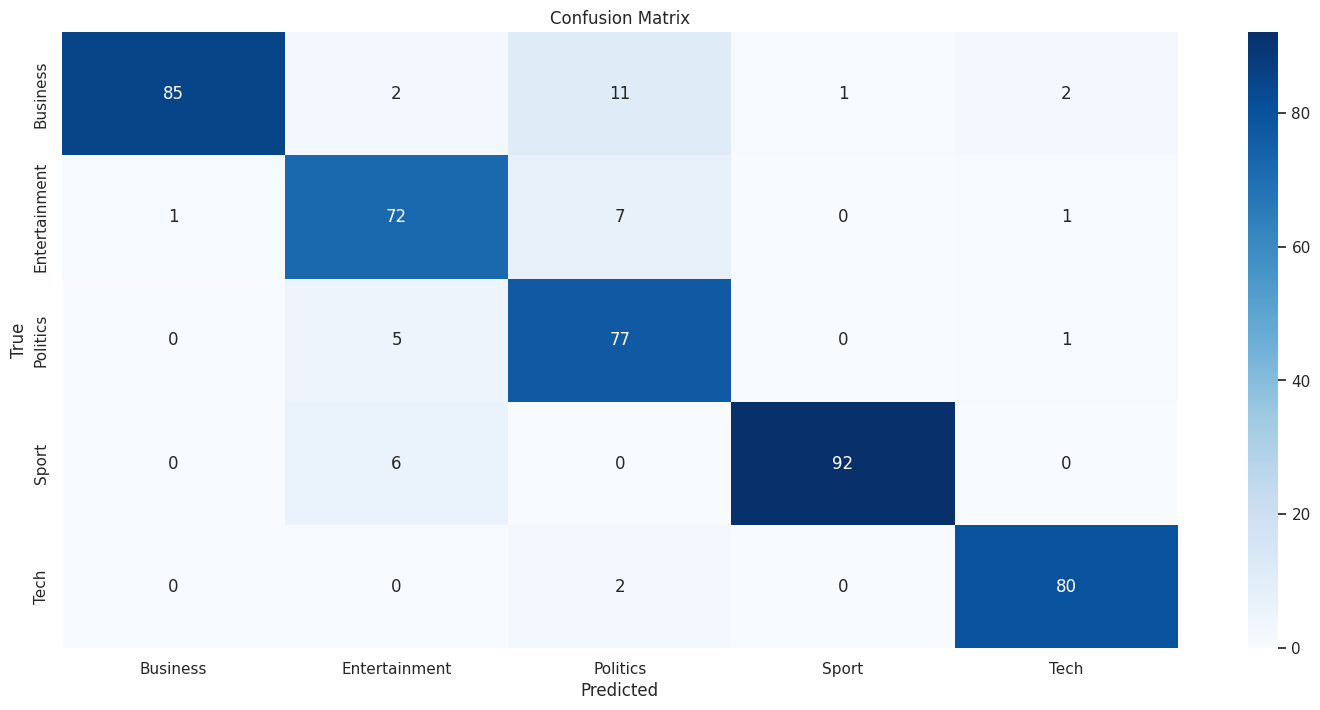

In [ ]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_text(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        sequences = tokenizer.texts_to_sequences([text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_text = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_text, probabilities.max()))

    return predictions

texts = [
    "cole faces lengthy injury lay-off aston villa s carlton cole could be out for six weeks with a knee injury. the striker who is on a season-long loan from chelsea picked up the knock in an england under-21 match against holland earlier this month. carlton will be out of action for four to six weeks after a bad challenge said villa boss david o leary. i won t be able to tell you whether he will need an operation until maybe next week. whether he has an operation has got to be left to chelsea. cole who also struggled with an ankle problem earlier in the season was unable to rest because o leary had a shortage of strikers. the return to fitness of darius vassell after four months out with a broken ankle and the emergence of luke moore has alleviated some of the villa s manager s problems in that department.",
    "berlin cheers for anti-nazi film a german movie about an anti-nazi resistance heroine has drawn loud applause at berlin film festival. sophie scholl - the final days portrays the final days of the member of the white rose movement. scholl 21 was arrested and beheaded with her brother hans in 1943 for distributing leaflets condemning the abhorrent tyranny of adolf hitler. director marc rothemund said: i have a feeling of responsibility to keep the legacy of the scholls going. we must somehow keep their ideas alive he added. the film drew on transcripts of gestapo interrogations and scholl s trial preserved in the archive of communist east germany s secret police. their discovery was the inspiration behind the film for rothemund who worked closely with surviving relatives including one of scholl s sisters to ensure historical accuracy on the film. scholl and other members of the white rose resistance group first started distributing anti-nazi leaflets in the summer of 1942. they were arrested as they dropped leaflets at munich university calling for a day of reckoning with adolf hitler s regime. the film focuses on the six days from scholl s arrest to the intense trial which saw scholl initially deny the charges and ended with a defiant appearance. it is one of three german films vying for a top prize at the festival. a south african film version of bizet s tragic opera carmen shot in cape town in the xhosa language has also premiered at the berlin festival. the film is entitled u-carmen ekhayelitsha or carmen in khayelitsha after the township in which the story is set. it is performed by a 40-strong music and theatre troupe in their debut film performance. the film is the first south african feature in 25 years and only the second to be nominated for a golden bear award.",
    "howard backs stem cell research michael howard has backed stem cell research saying it is important people are not frightened of the future. the controversial issue was a feature of the recent us presidential election where george bush opposed extending it. but the tory leader argued there was a moral case for embracing science which could help victims of alzheimer s parkinson s and motor neurone disease. i believe we have a duty to offer hope to the millions of people who suffer devastating illnesses he said. the use of embryonic stem cells in the uk is already allowed. stem cells are master cells that have the ability to develop into any of the body s tissue types. scientists hope that by growing such cells in the laboratory they can programme them to form specific tissue such as kidney heart or even brain tissue. mr howard acknowledged there were genuine concerns about stem cell research. but he argued: we mustn t be frightened of change or nostalgic about the past - we must be optimistic about the future. politicians must create the right framework so that the great potential of science can be harnessed for the benefit of mankind. with the life expectancy of the average briton now around the mid-70s society has a responsibility to enhance the quality of people s lives as they grow older. i know many people are concerned about stem-cell research. they are fearful of meddling with what they see as the stuff of souls. i respect those concerns. but i also believe we have a duty to offer hope to the millions of people who suffer devastating illnesses like parkinson s multiple sclerosis motor neurone disease alzheimer s and - as we saw in the papers today - now possibly heart problems. mr howard acknowledged there were no easy answers over such an issue but it was necessary to have the courage to do what we know to be morally right . he added: of course stem cells are still a recent discovery. more research needs to be done. but we must look at their potential in a responsible and grown-up way. the hopes of millions of people rest on what could be achieved. former superman actor the late christopher reeve was an advocate for the research after he was paralysed in a horse riding accident. mr howard made his remarks during a speech in westminster to the conservative national women s committee on ambitions and values.",
    "security warning over fbi virus the us federal bureau of investigation is warning that a computer virus is being spread via e-mails that purport to be from the fbi. the e-mails show that they have come from an fbi.gov address and tell recipients that they have accessed illegal websites. the messages warn that their internet use has been monitored by the fbi s internet fraud complaint center. an attachment in the e-mail contains the virus the fbi said. the message asks recipients to click on the attachment and answer some questions about their internet use. but rather than being a questionnaire the attachment contains a virus that infects the recipient s computer according to the agency. it is not clear what the virus does once it has infected a computer. users are warned never to open attachment from unsolicited e-mails or from people they do not know. recipients of this or similar solicitations should know that the fbi does not engage in the practice of sending unsolicited e-mails to the public in this manner the fbi said in a statement. the bureau is investigating the phoney e-mails. the agency earlier this month shut down fbi.gov accounts used to communicate with the public because of a security breach. a spokeswoman said the two incidents appear to be unrelated."
]

predicted_texts = predict_text( texts, model_gru, tokenizer, max_length, label_encoder)

for text, (predicted_text, probability) in zip(texts, predicted_texts):
    print(f"Text: '{text}'")
    print(f"Predicted Category: {predicted_text}")
    print(f"Probability of {predicted_text}: {probability:.4f}\n")


1/1 [==============================] - 1s 1s/step
Text: 'cole faces lengthy injury lay-off aston villa s carlton cole could be out for six weeks with a knee injury. the striker who is on a season-long loan from chelsea picked up the knock in an england under-21 match against holland earlier this month. carlton will be out of action for four to six weeks after a bad challenge said villa boss david o leary. i won t be able to tell you whether he will need an operation until maybe next week. whether he has an operation has got to be left to chelsea. cole who also struggled with an ankle problem earlier in the season was unable to rest because o leary had a shortage of strikers. the return to fitness of darius vassell after four months out with a broken ankle and the emergence of luke moore has alleviated some of the villa s manager s problems in that department.'
Predicted Language: Sport
Probability of Sport: 1.0000

Text: 'berlin cheers for anti-nazi film a german movie about an anti-na

##CNN Model Training and Evaluation

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_cnn.add(Conv1D(64, 2, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(128, 2, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 768, 128)          3442688   
                                                                 
 conv1d (Conv1D)             (None, 767, 64)           16448     
                                                                 
 max_pooling1d (MaxPooling1  (None, 383, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 382, 128)          16512     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 191, 128)          0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 24448)            

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="cnn-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks3=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_cnn= model_cnn.fit(XX_train, y_train, validation_data=(XX_test, y_test), epochs=5, batch_size=64, callbacks=callbacks3)

Epoch 1/5
28/28 [==============================] - 14s 497ms/step - loss: 1.5001 - accuracy: 0.3287 - val_loss: 1.3742 - val_accuracy: 0.4360 - lr: 0.0010
Epoch 2/5
28/28 [==============================] - 7s 246ms/step - loss: 0.8658 - accuracy: 0.7045 - val_loss: 0.5304 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/5
28/28 [==============================] - 5s 196ms/step - loss: 0.1403 - accuracy: 0.9629 - val_loss: 0.2682 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 4/5
28/28 [==============================] - 4s 149ms/step - loss: 0.0211 - accuracy: 0.9949 - val_loss: 0.1632 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 5/5
28/28 [==============================] - 7s 233ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.1491 - val_accuracy: 0.9506 - lr: 0.0010


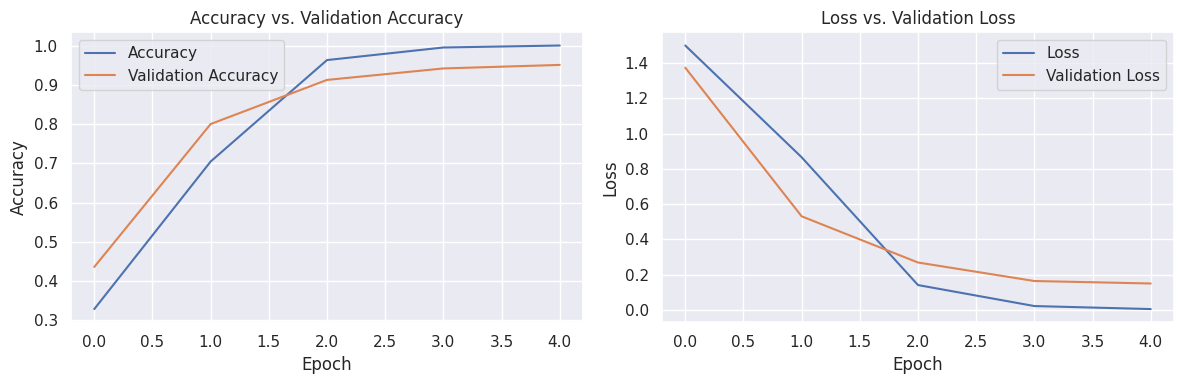

In [ ]:
accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
hist_=pd.DataFrame(history_cnn.history)
hist_

loss  accuracy  val_loss  val_accuracy     lr
0  1.500071  0.328652  1.374181      0.435955  0.001
1  0.865760  0.704494  0.530416      0.800000  0.001
2  0.140265  0.962921  0.268228      0.912360  0.001
3  0.021090  0.994944  0.163216      0.941573  0.001
4  0.003948  1.000000  0.149146      0.950562  0.001

In [ ]:
loss, accuracy = model_cnn.evaluate(XX_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

14/14 [==============================] - 0s 13ms/step - loss: 0.1491 - accuracy: 0.9506
Test Loss: 0.1491
Test Accuracy: 95.06%


In [ ]:
class_names = label_encoder.classes_


y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_cnn.predict(XX_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

14/14 [==============================] - 1s 7ms/step
Classification Report:
                precision    recall  f1-score   support

     Business       0.94      0.91      0.92       101
Entertainment       1.00      0.89      0.94        81
     Politics       0.86      1.00      0.92        83
        Sport       0.99      0.99      0.99        98
         Tech       0.99      0.96      0.98        82

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



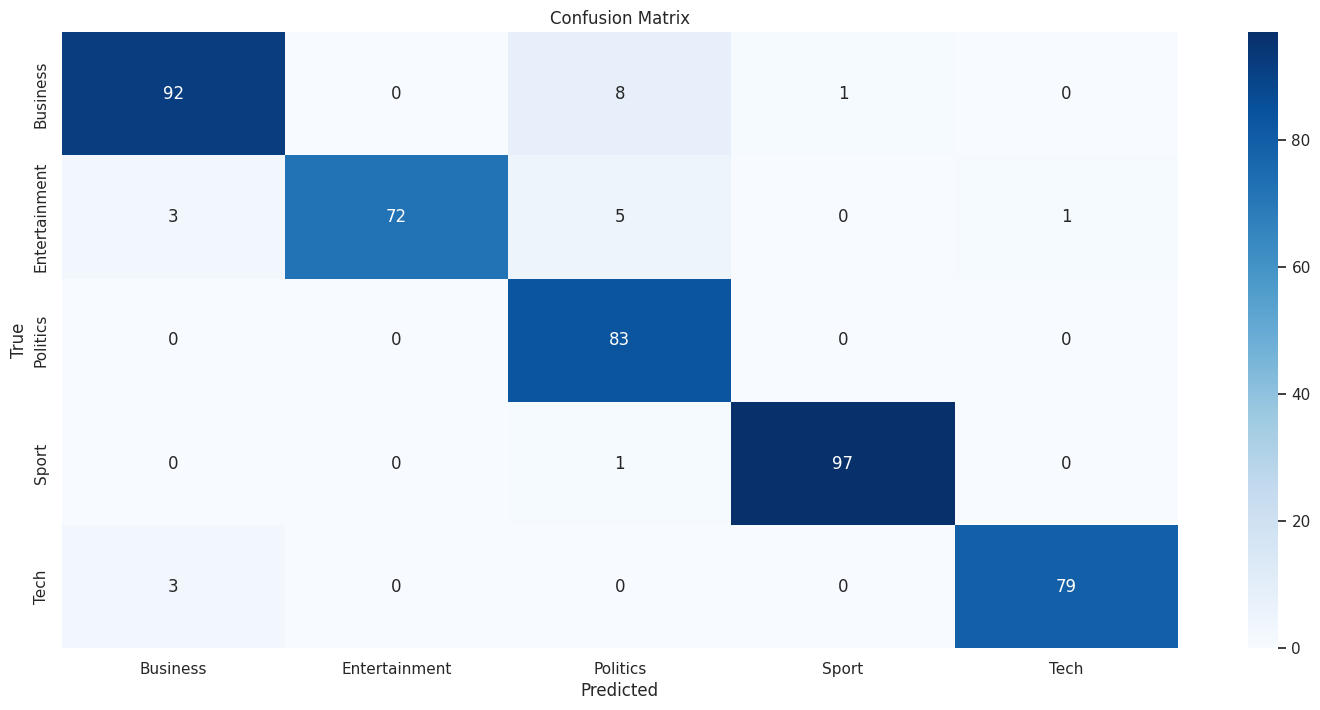

In [ ]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_text(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        sequences = tokenizer.texts_to_sequences([text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_text = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_text, probabilities.max()))

    return predictions

texts = [
    "cole faces lengthy injury lay-off aston villa s carlton cole could be out for six weeks with a knee injury. the striker who is on a season-long loan from chelsea picked up the knock in an england under-21 match against holland earlier this month. carlton will be out of action for four to six weeks after a bad challenge said villa boss david o leary. i won t be able to tell you whether he will need an operation until maybe next week. whether he has an operation has got to be left to chelsea. cole who also struggled with an ankle problem earlier in the season was unable to rest because o leary had a shortage of strikers. the return to fitness of darius vassell after four months out with a broken ankle and the emergence of luke moore has alleviated some of the villa s manager s problems in that department.",
    "berlin cheers for anti-nazi film a german movie about an anti-nazi resistance heroine has drawn loud applause at berlin film festival. sophie scholl - the final days portrays the final days of the member of the white rose movement. scholl 21 was arrested and beheaded with her brother hans in 1943 for distributing leaflets condemning the abhorrent tyranny of adolf hitler. director marc rothemund said: i have a feeling of responsibility to keep the legacy of the scholls going. we must somehow keep their ideas alive he added. the film drew on transcripts of gestapo interrogations and scholl s trial preserved in the archive of communist east germany s secret police. their discovery was the inspiration behind the film for rothemund who worked closely with surviving relatives including one of scholl s sisters to ensure historical accuracy on the film. scholl and other members of the white rose resistance group first started distributing anti-nazi leaflets in the summer of 1942. they were arrested as they dropped leaflets at munich university calling for a day of reckoning with adolf hitler s regime. the film focuses on the six days from scholl s arrest to the intense trial which saw scholl initially deny the charges and ended with a defiant appearance. it is one of three german films vying for a top prize at the festival. a south african film version of bizet s tragic opera carmen shot in cape town in the xhosa language has also premiered at the berlin festival. the film is entitled u-carmen ekhayelitsha or carmen in khayelitsha after the township in which the story is set. it is performed by a 40-strong music and theatre troupe in their debut film performance. the film is the first south african feature in 25 years and only the second to be nominated for a golden bear award.",
    "howard backs stem cell research michael howard has backed stem cell research saying it is important people are not frightened of the future. the controversial issue was a feature of the recent us presidential election where george bush opposed extending it. but the tory leader argued there was a moral case for embracing science which could help victims of alzheimer s parkinson s and motor neurone disease. i believe we have a duty to offer hope to the millions of people who suffer devastating illnesses he said. the use of embryonic stem cells in the uk is already allowed. stem cells are master cells that have the ability to develop into any of the body s tissue types. scientists hope that by growing such cells in the laboratory they can programme them to form specific tissue such as kidney heart or even brain tissue. mr howard acknowledged there were genuine concerns about stem cell research. but he argued: we mustn t be frightened of change or nostalgic about the past - we must be optimistic about the future. politicians must create the right framework so that the great potential of science can be harnessed for the benefit of mankind. with the life expectancy of the average briton now around the mid-70s society has a responsibility to enhance the quality of people s lives as they grow older. i know many people are concerned about stem-cell research. they are fearful of meddling with what they see as the stuff of souls. i respect those concerns. but i also believe we have a duty to offer hope to the millions of people who suffer devastating illnesses like parkinson s multiple sclerosis motor neurone disease alzheimer s and - as we saw in the papers today - now possibly heart problems. mr howard acknowledged there were no easy answers over such an issue but it was necessary to have the courage to do what we know to be morally right . he added: of course stem cells are still a recent discovery. more research needs to be done. but we must look at their potential in a responsible and grown-up way. the hopes of millions of people rest on what could be achieved. former superman actor the late christopher reeve was an advocate for the research after he was paralysed in a horse riding accident. mr howard made his remarks during a speech in westminster to the conservative national women s committee on ambitions and values.",
    "security warning over fbi virus the us federal bureau of investigation is warning that a computer virus is being spread via e-mails that purport to be from the fbi. the e-mails show that they have come from an fbi.gov address and tell recipients that they have accessed illegal websites. the messages warn that their internet use has been monitored by the fbi s internet fraud complaint center. an attachment in the e-mail contains the virus the fbi said. the message asks recipients to click on the attachment and answer some questions about their internet use. but rather than being a questionnaire the attachment contains a virus that infects the recipient s computer according to the agency. it is not clear what the virus does once it has infected a computer. users are warned never to open attachment from unsolicited e-mails or from people they do not know. recipients of this or similar solicitations should know that the fbi does not engage in the practice of sending unsolicited e-mails to the public in this manner the fbi said in a statement. the bureau is investigating the phoney e-mails. the agency earlier this month shut down fbi.gov accounts used to communicate with the public because of a security breach. a spokeswoman said the two incidents appear to be unrelated."
]

predicted_texts = predict_text( texts, model_cnn, tokenizer, max_length, label_encoder)

for text, (predicted_text, probability) in zip(texts, predicted_texts):
    print(f"Text: '{text}'")
    print(f"Predicted Category: {predicted_text}")
    print(f"Probability of {predicted_text}: {probability:.4f}\n")


1/1 [==============================] - 0s 57ms/step
Text: 'cole faces lengthy injury lay-off aston villa s carlton cole could be out for six weeks with a knee injury. the striker who is on a season-long loan from chelsea picked up the knock in an england under-21 match against holland earlier this month. carlton will be out of action for four to six weeks after a bad challenge said villa boss david o leary. i won t be able to tell you whether he will need an operation until maybe next week. whether he has an operation has got to be left to chelsea. cole who also struggled with an ankle problem earlier in the season was unable to rest because o leary had a shortage of strikers. the return to fitness of darius vassell after four months out with a broken ankle and the emergence of luke moore has alleviated some of the villa s manager s problems in that department.'
Predicted Language: Sport
Probability of Sport: 0.9991

Text: 'berlin cheers for anti-nazi film a german movie about an anti-

##Hybrid Model Training and Evaluation

In [ ]:
model_hb = Sequential()
model_hb.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_hb.add(Conv1D(128, 2, activation='relu'))
model_hb.add(MaxPooling1D(2))
model_hb.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_hb.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_hb.add(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_hb.add(Flatten())
model_hb.add(Dense(128, activation='relu'))
model_hb.add(Dropout(0.3))
model_hb.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_hb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_hb.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 768, 128)          3442688   
                                                                 
 conv1d_6 (Conv1D)           (None, 767, 128)          32896     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 383, 128)          0         
 g1D)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 383, 128)          131584    
                                                                 
 lstm_6 (LSTM)               (None, 383, 64)           49408     
                                                                 
 lstm_7 (LSTM)               (None, 383, 32)           12416     
                                                     

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="hb-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks4=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_hb= model_hb.fit(XX_train, y_train, validation_data=(XX_test, y_test), epochs=5, batch_size=64, callbacks=callbacks4 )

Epoch 1/5
28/28 [==============================] - 174s 6s/step - loss: 1.5166 - accuracy: 0.3022 - val_loss: 1.2603 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 2/5
28/28 [==============================] - 154s 5s/step - loss: 0.7244 - accuracy: 0.7174 - val_loss: 0.5176 - val_accuracy: 0.8449 - lr: 0.0010
Epoch 3/5
28/28 [==============================] - 161s 6s/step - loss: 0.1538 - accuracy: 0.9438 - val_loss: 0.2771 - val_accuracy: 0.9034 - lr: 0.0010
Epoch 4/5
28/28 [==============================] - 155s 6s/step - loss: 0.0409 - accuracy: 0.9882 - val_loss: 0.4913 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 5/5
28/28 [==============================] - 158s 6s/step - loss: 0.0456 - accuracy: 0.9871 - val_loss: 0.2823 - val_accuracy: 0.9146 - lr: 0.0010


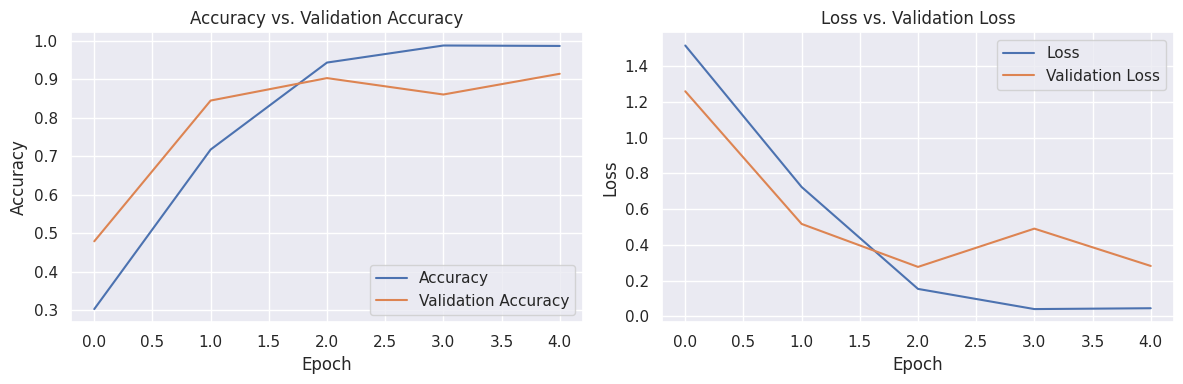

In [ ]:
accuracy = history_hb.history['accuracy']
val_accuracy = history_hb.history['val_accuracy']
loss = history_hb.history['loss']
val_loss = history_hb.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
hist_=pd.DataFrame(history_hb.history)
hist_

loss  accuracy  val_loss  val_accuracy     lr
0  1.516582  0.302247  1.260307      0.478652  0.001
1  0.724403  0.717416  0.517596      0.844944  0.001
2  0.153820  0.943820  0.277053      0.903371  0.001
3  0.040924  0.988202  0.491295      0.860674  0.001
4  0.045605  0.987079  0.282345      0.914607  0.001

In [ ]:
loss, accuracy = model_hb.evaluate(XX_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

14/14 [==============================] - 8s 522ms/step - loss: 0.2823 - accuracy: 0.9146
Test Loss: 0.2823
Test Accuracy: 91.46%


In [ ]:
class_names = label_encoder.classes_


y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_hb.predict(XX_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

14/14 [==============================] - 11s 607ms/step
Classification Report:
                precision    recall  f1-score   support

     Business       0.90      0.85      0.87       101
Entertainment       0.82      0.93      0.87        81
     Politics       0.91      0.94      0.92        83
        Sport       1.00      0.94      0.97        98
         Tech       0.95      0.93      0.94        82

     accuracy                           0.91       445
    macro avg       0.92      0.92      0.91       445
 weighted avg       0.92      0.91      0.92       445



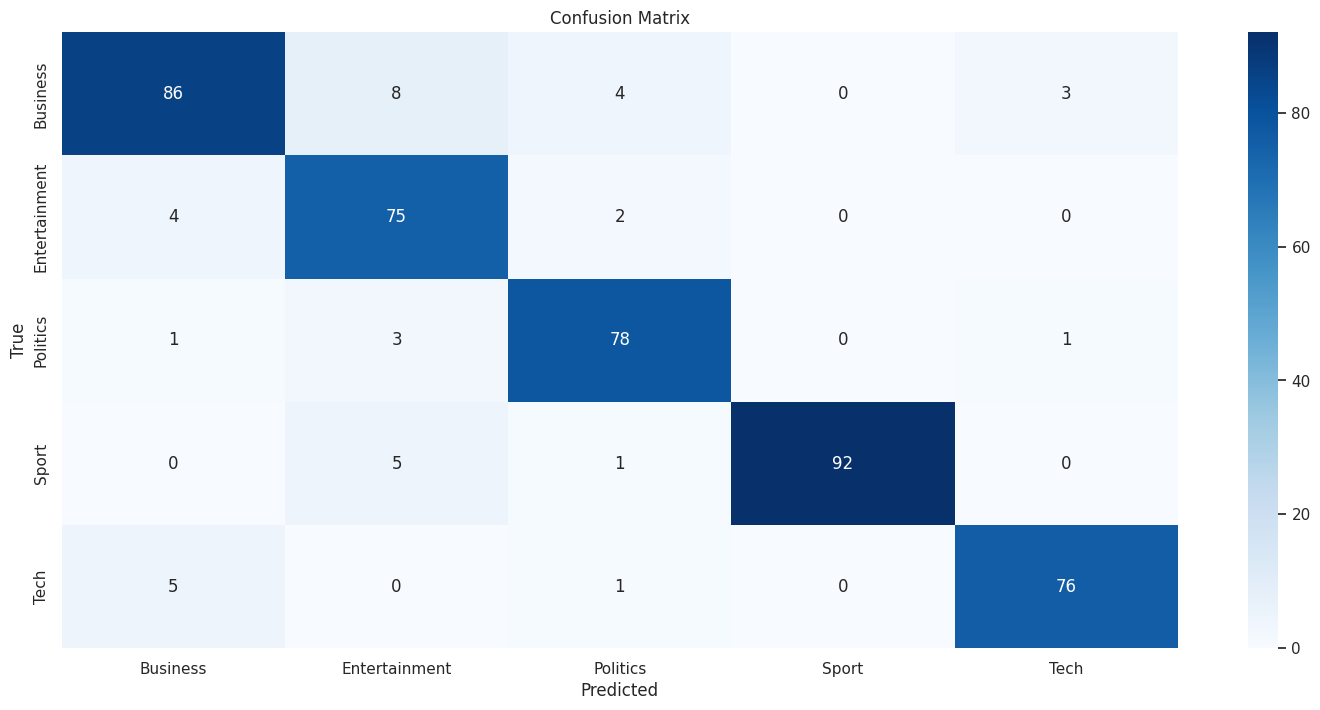

In [ ]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_text(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        sequences = tokenizer.texts_to_sequences([text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_text = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_text, probabilities.max()))

    return predictions

texts = [
    "cole faces lengthy injury lay-off aston villa s carlton cole could be out for six weeks with a knee injury. the striker who is on a season-long loan from chelsea picked up the knock in an england under-21 match against holland earlier this month. carlton will be out of action for four to six weeks after a bad challenge said villa boss david o leary. i won t be able to tell you whether he will need an operation until maybe next week. whether he has an operation has got to be left to chelsea. cole who also struggled with an ankle problem earlier in the season was unable to rest because o leary had a shortage of strikers. the return to fitness of darius vassell after four months out with a broken ankle and the emergence of luke moore has alleviated some of the villa s manager s problems in that department.",
    "berlin cheers for anti-nazi film a german movie about an anti-nazi resistance heroine has drawn loud applause at berlin film festival. sophie scholl - the final days portrays the final days of the member of the white rose movement. scholl 21 was arrested and beheaded with her brother hans in 1943 for distributing leaflets condemning the abhorrent tyranny of adolf hitler. director marc rothemund said: i have a feeling of responsibility to keep the legacy of the scholls going. we must somehow keep their ideas alive he added. the film drew on transcripts of gestapo interrogations and scholl s trial preserved in the archive of communist east germany s secret police. their discovery was the inspiration behind the film for rothemund who worked closely with surviving relatives including one of scholl s sisters to ensure historical accuracy on the film. scholl and other members of the white rose resistance group first started distributing anti-nazi leaflets in the summer of 1942. they were arrested as they dropped leaflets at munich university calling for a day of reckoning with adolf hitler s regime. the film focuses on the six days from scholl s arrest to the intense trial which saw scholl initially deny the charges and ended with a defiant appearance. it is one of three german films vying for a top prize at the festival. a south african film version of bizet s tragic opera carmen shot in cape town in the xhosa language has also premiered at the berlin festival. the film is entitled u-carmen ekhayelitsha or carmen in khayelitsha after the township in which the story is set. it is performed by a 40-strong music and theatre troupe in their debut film performance. the film is the first south african feature in 25 years and only the second to be nominated for a golden bear award.",
    "howard backs stem cell research michael howard has backed stem cell research saying it is important people are not frightened of the future. the controversial issue was a feature of the recent us presidential election where george bush opposed extending it. but the tory leader argued there was a moral case for embracing science which could help victims of alzheimer s parkinson s and motor neurone disease. i believe we have a duty to offer hope to the millions of people who suffer devastating illnesses he said. the use of embryonic stem cells in the uk is already allowed. stem cells are master cells that have the ability to develop into any of the body s tissue types. scientists hope that by growing such cells in the laboratory they can programme them to form specific tissue such as kidney heart or even brain tissue. mr howard acknowledged there were genuine concerns about stem cell research. but he argued: we mustn t be frightened of change or nostalgic about the past - we must be optimistic about the future. politicians must create the right framework so that the great potential of science can be harnessed for the benefit of mankind. with the life expectancy of the average briton now around the mid-70s society has a responsibility to enhance the quality of people s lives as they grow older. i know many people are concerned about stem-cell research. they are fearful of meddling with what they see as the stuff of souls. i respect those concerns. but i also believe we have a duty to offer hope to the millions of people who suffer devastating illnesses like parkinson s multiple sclerosis motor neurone disease alzheimer s and - as we saw in the papers today - now possibly heart problems. mr howard acknowledged there were no easy answers over such an issue but it was necessary to have the courage to do what we know to be morally right . he added: of course stem cells are still a recent discovery. more research needs to be done. but we must look at their potential in a responsible and grown-up way. the hopes of millions of people rest on what could be achieved. former superman actor the late christopher reeve was an advocate for the research after he was paralysed in a horse riding accident. mr howard made his remarks during a speech in westminster to the conservative national women s committee on ambitions and values.",
    "security warning over fbi virus the us federal bureau of investigation is warning that a computer virus is being spread via e-mails that purport to be from the fbi. the e-mails show that they have come from an fbi.gov address and tell recipients that they have accessed illegal websites. the messages warn that their internet use has been monitored by the fbi s internet fraud complaint center. an attachment in the e-mail contains the virus the fbi said. the message asks recipients to click on the attachment and answer some questions about their internet use. but rather than being a questionnaire the attachment contains a virus that infects the recipient s computer according to the agency. it is not clear what the virus does once it has infected a computer. users are warned never to open attachment from unsolicited e-mails or from people they do not know. recipients of this or similar solicitations should know that the fbi does not engage in the practice of sending unsolicited e-mails to the public in this manner the fbi said in a statement. the bureau is investigating the phoney e-mails. the agency earlier this month shut down fbi.gov accounts used to communicate with the public because of a security breach. a spokeswoman said the two incidents appear to be unrelated."
]

predicted_texts = predict_text( texts, model_hb, tokenizer, max_length, label_encoder)

for text, (predicted_text, probability) in zip(texts, predicted_texts):
    print(f"Text: '{text}'")
    print(f"Predicted Category: {predicted_text}")
    print(f"Probability of {predicted_text}: {probability:.4f}\n")


1/1 [==============================] - 1s 704ms/step
Text: 'cole faces lengthy injury lay-off aston villa s carlton cole could be out for six weeks with a knee injury. the striker who is on a season-long loan from chelsea picked up the knock in an england under-21 match against holland earlier this month. carlton will be out of action for four to six weeks after a bad challenge said villa boss david o leary. i won t be able to tell you whether he will need an operation until maybe next week. whether he has an operation has got to be left to chelsea. cole who also struggled with an ankle problem earlier in the season was unable to rest because o leary had a shortage of strikers. the return to fitness of darius vassell after four months out with a broken ankle and the emergence of luke moore has alleviated some of the villa s manager s problems in that department.'
Predicted Language: Sport
Probability of Sport: 0.9994

Text: 'berlin cheers for anti-nazi film a german movie about an anti

##Bert Model for Text Classification

###Data Preprocessing and Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.20, random_state=42)

X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

class_names = ['sport', 'business', 'politics','tech', 'entertainment']

###Fine-Tuning BERT

In [ ]:
(x_train,y_train), (x_val,y_val), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=512,
                                                                       max_features=20000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


task: text classification


In [ ]:
model = text.text_classifier('bert', train_data=(x_train,y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 512


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


In [ ]:
learner = ktrain.get_learner(model, train_data=(x_train,y_train),
                             val_data=(x_val,y_val),
                             batch_size=6)

In [ ]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
297/297 [==============================] - 289s 877ms/step - loss: 0.6092 - accuracy: 0.8230 - val_loss: 0.0821 - val_accuracy: 0.9865
Epoch 2/3
297/297 [==============================] - 264s 889ms/step - loss: 0.0849 - accuracy: 0.9742 - val_loss: 0.1858 - val_accuracy: 0.9551
Epoch 3/3
297/297 [==============================] - 264s 888ms/step - loss: 0.0276 - accuracy: 0.9921 - val_loss: 0.0618 - val_accuracy: 0.9820


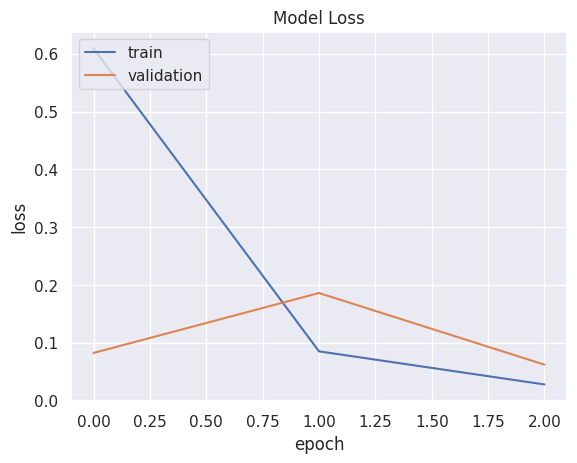

In [ ]:
learner.plot()

In [ ]:
learner.validate(val_data=(x_val,y_val), class_names=class_names)

14/14 [==============================] - 23s 1s/step
               precision    recall  f1-score   support

        sport       0.99      0.93      0.96       101
     business       1.00      1.00      1.00        81
     politics       0.95      1.00      0.98        83
         tech       0.99      1.00      0.99        98
entertainment       0.98      0.99      0.98        82

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



array([[94,  0,  4,  1,  2],
       [ 0, 81,  0,  0,  0],
       [ 0,  0, 83,  0,  0],
       [ 0,  0,  0, 98,  0],
       [ 1,  0,  0,  0, 81]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['Business', 'Entertainment', 'Politics', 'Sport', 'Tech']

In [ ]:
message = "Taylor Swift's upcoming album release and her collaborations with other prominent artists would be the focus of the entertainment news story. The article would likely include details about the album, the release date, and the artists she's collaborating with, generating excitement among her fans and the wider entertainment industry."
prediction = predictor.predict(message)
print('predicted: {}'.format(prediction))

predicted: Entertainment


**Save Bert Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
predictor.save("/content/drive/MyDrive/Colab_Notebooks/DL Model/Bert_Model_Text_Classification")

**Load Saved Model and Predict**

In [ ]:
predictor1 = ktrain.load_predictor('/content/drive/MyDrive/Colab_Notebooks/DL Model/Bert_Model_Text_Classification')

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
data = "One of the biggest challenges facing politicians today is the growing divide between the rich and poor. The concentration of wealth in the hands of a few individuals is a major threat to our democracy, as it allows a small group of people to exert an outsized influence on our political system."
predictor1.predict(data)

'politics'

##XLNet Model for Text Classification

###Data Preprocessing and Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.25, random_state=42)

X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

###Fine-Tuning XLNet

In [ ]:
model_name = 'xlnet-base-cased'
trans = text.Transformer(model_name, maxlen = 512, classes = ['sport', 'business', 'politics','tech', 'entertainment'])

/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:382: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(


In [ ]:
train_data = trans.preprocess_train(X_train, y_train)
test_data = trans.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 388
	95percentile : 734
	99percentile : 948


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 400
	95percentile : 756
	99percentile : 1328


In [ ]:
model = trans.get_classifier()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=test_data, batch_size=6)

In [ ]:
learner.fit_onecycle(lr=2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
297/297 [==============================] - 532s 2s/step - loss: 0.4149 - accuracy: 0.8764 - val_loss: 0.0540 - val_accuracy: 0.9843
Epoch 2/3
297/297 [==============================] - 509s 2s/step - loss: 0.0957 - accuracy: 0.9753 - val_loss: 0.0753 - val_accuracy: 0.9708
Epoch 3/3
297/297 [==============================] - 509s 2s/step - loss: 0.0276 - accuracy: 0.9927 - val_loss: 0.0749 - val_accuracy: 0.9775


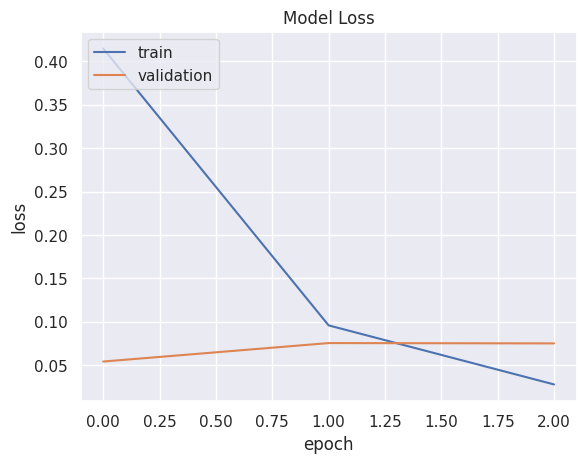

In [ ]:
learner.plot()

In [ ]:
learner.validate(val_data=test_data, class_names=trans.get_classes())#Lol, need more gpu memory

14/14 [==============================] - 41s 3s/step


InternalError: ignored

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc= trans)
predictor.get_classes()

['Business', 'Entertainment', 'Politics', 'Sport', 'Tech']

In [ ]:
predictions = predictor.predict("One of the most exciting technological advancements in recent years has been the rise of artificial intelligence (AI) and machine learning (ML) technologies. These technologies have the potential to revolutionize countless industries, from healthcare and finance to manufacturing and transportation.")
print('predicted: {}'.format(predictions))

predicted: Tech


In [ ]:
predictor.save("/content/drive/MyDrive/Colab_Notebooks/DL Model/xlnet_model_Text_Classification")

In [ ]:
predictor1 = ktrain.load_predictor('/content/drive/MyDrive/Colab_Notebooks/DL Model/xlnet_model_Text_Classification')

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
data = "Politics can be a messy business, but it's essential to the functioning of our society. At its core, politics is about making decisions that affect the lives of millions of people. It's about figuring out how to allocate resources, provide public services, and ensure that everyone has a say in the decisions that affect them."
predictor1.predict(data)

'politics'